# Proyecto Machine Learning Dev.F

### En este proyecto usaré un dataset con mediciones de radiactividad por metro cúbico (radones) de diferentes isótopos radiactivos liberados por la explosión del reactor No. 4 de la planta nuclear de Chernobyl en diferentes lugares de Europa.

### La incógnita importante que quiero responder es: Qué tan bien se puede predecir los niveles de radiación que afectarían a los países vecinos en dado caso que el accidente se repitiera basándome en distancia de separación.

### ¿Qué tanto afecta la lejanía con el nivel de medición de radiación ?

In [198]:
!pip install kaggle
!pip install scikit-optimize

In [199]:
!kaggle datasets download -d brsdincer/chernobyl-chemical-radiation-csv-country-data

chernobyl-chemical-radiation-csv-country-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [200]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from sklearn.neighbors import DistanceMetric
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Integer, Categorical
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile

In [201]:
with zipfile.ZipFile('chernobyl-chemical-radiation-csv-country-data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')    

In [202]:
df = pd.read_csv('./Chernobyl_ Chemical_Radiation.csv')
df.head()

,PAYS,Code,Location,Longitude,Latitude,Date,I_131_(Bq/m3),Cs_134_(Bq/m3),Cs_137_(Bq/m3)
0,SE,1,RISOE,12.07,55.7,86/04/27,1,0,0.24
1,SE,1,RISOE,12.07,55.7,86/04/28,0.0046,0.00054,0.00098
2,SE,1,RISOE,12.07,55.7,86/04/29,0.0147,0.0043,0.0074
3,SE,1,RISOE,12.07,55.7,86/04/29,0.00061,0,0.00009
4,SE,1,RISOE,12.07,55.7,86/04/30,0.00075,0.0001,0.00028


In [203]:
df.columns

Index(['PAYS', 'Code', 'Location', 'Longitude', 'Latitude', 'Date',
       'I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)'],
      dtype='object')

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PAYS            2051 non-null   object 
 1   Code            2051 non-null   int64  
 2   Location        2051 non-null   object 
 3   Longitude       2051 non-null   float64
 4   Latitude        2051 non-null   float64
 5   Date            2051 non-null   object 
 6   I_131_(Bq/m3)   2031 non-null   object 
 7   Cs_134_(Bq/m3)  1897 non-null   object 
 8   Cs_137_(Bq/m3)  1571 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 144.3+ KB


In [205]:
df.isnull().sum()

PAYS                0
Code                0
Location            0
Longitude           0
Latitude            0
Date                0
I_131_(Bq/m3)      20
Cs_134_(Bq/m3)    154
Cs_137_(Bq/m3)    480
dtype: int64

In [206]:
df['PAYS'].value_counts()

IT    303
F     260
DE    246
AU    223
SE    211
CZ    134
NL    121
UK    119
FI    107
NO     73
BE     72
GR     60
ES     44
CH     42
IR     23
HU     13
Name: PAYS, dtype: int64

In [207]:
df.rename(columns={"PAYS":'Country',
                    "I_131_(Bq/m3)":"Iodine_131",
                    "Cs_134_(Bq/m3)":"Caesium_134",
                    "Cs_137_(Bq/m3)":"Caesium_137"}, inplace = True)
df.head()

,Country,Code,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137
0,SE,1,RISOE,12.07,55.7,86/04/27,1,0,0.24
1,SE,1,RISOE,12.07,55.7,86/04/28,0.0046,0.00054,0.00098
2,SE,1,RISOE,12.07,55.7,86/04/29,0.0147,0.0043,0.0074
3,SE,1,RISOE,12.07,55.7,86/04/29,0.00061,0,0.00009
4,SE,1,RISOE,12.07,55.7,86/04/30,0.00075,0.0001,0.00028


In [208]:
df.replace({'AU': 'Austria',
                       'BE': 'Belgium',
                       'CH': 'Switzerland',
                       'CZ': 'Czechoslovakia',
                       'DE': 'Germany',
                       'ES': 'Spain',
                       'F': 'France',
                       'FI': 'Finland',
                       'GR': 'Greece',
                       'HU': 'Hungary',
                       'IR': 'Ireland',
                       'IT': 'Italy',
                       'NL': 'Netherlands',
                       'NO': 'Norway',
                       'SE': 'Sweden',
                       'UK': 'United Kingdom'}, inplace = True)
df.head()

,Country,Code,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137
0,Sweden,1,RISOE,12.07,55.7,86/04/27,1,0,0.24
1,Sweden,1,RISOE,12.07,55.7,86/04/28,0.0046,0.00054,0.00098
2,Sweden,1,RISOE,12.07,55.7,86/04/29,0.0147,0.0043,0.0074
3,Sweden,1,RISOE,12.07,55.7,86/04/29,0.00061,0,0.00009
4,Sweden,1,RISOE,12.07,55.7,86/04/30,0.00075,0.0001,0.00028


In [209]:
df.drop(['Code'], axis = 1, inplace = True)
df.head()

,Country,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137
0,Sweden,RISOE,12.07,55.7,86/04/27,1,0,0.24
1,Sweden,RISOE,12.07,55.7,86/04/28,0.0046,0.00054,0.00098
2,Sweden,RISOE,12.07,55.7,86/04/29,0.0147,0.0043,0.0074
3,Sweden,RISOE,12.07,55.7,86/04/29,0.00061,0,0.00009
4,Sweden,RISOE,12.07,55.7,86/04/30,0.00075,0.0001,0.00028


In [210]:
df[["Iodine_131","Caesium_134","Caesium_137"]] = df[["Iodine_131","Caesium_134","Caesium_137"]].replace("<", np.NaN)
df[["Iodine_131","Caesium_134","Caesium_137"]] = df[["Iodine_131","Caesium_134","Caesium_137"]].replace("L", np.NaN)
df[["Iodine_131","Caesium_134","Caesium_137"]] = df[["Iodine_131","Caesium_134","Caesium_137"]].replace("N", np.NaN)

df[["Iodine_131","Caesium_134","Caesium_137"]] = df[["Iodine_131","Caesium_134","Caesium_137"]].apply(pd.to_numeric)


In [211]:
df.isna().sum()

Country          0
Location         0
Longitude        0
Latitude         0
Date             0
Iodine_131      42
Caesium_134    250
Caesium_137    545
dtype: int64

In [212]:
df["Iodine_131"].fillna(df.groupby(["Country"])["Iodine_131"].transform("mean"), inplace = True)
df["Caesium_134"].fillna(df.groupby(["Country"])["Caesium_134"].transform("mean"), inplace = True)
df["Caesium_137"].fillna(df.groupby(["Country"])["Caesium_137"].transform("mean"), inplace = True)
df.isna().sum()

Country         0
Location        0
Longitude       0
Latitude        0
Date            0
Iodine_131      0
Caesium_134     0
Caesium_137    23
dtype: int64

In [213]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2028 entries, 0 to 2050
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      2028 non-null   object 
 1   Location     2028 non-null   object 
 2   Longitude    2028 non-null   float64
 3   Latitude     2028 non-null   float64
 4   Date         2028 non-null   object 
 5   Iodine_131   2028 non-null   float64
 6   Caesium_134  2028 non-null   float64
 7   Caesium_137  2028 non-null   float64
dtypes: float64(5), object(3)
memory usage: 142.6+ KB


In [214]:
df.head()

,Country,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137
0,Sweden,RISOE,12.07,55.7,86/04/27,1.00000,0.00000,0.24000
1,Sweden,RISOE,12.07,55.7,86/04/28,0.00460,0.00054,0.00098
2,Sweden,RISOE,12.07,55.7,86/04/29,0.01470,0.00430,0.00740
3,Sweden,RISOE,12.07,55.7,86/04/29,0.00061,0.00000,0.00009
4,Sweden,RISOE,12.07,55.7,86/04/30,0.00075,0.00010,0.00028


In [215]:
df["Country"] = pd.Categorical(df["Country"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2028 entries, 0 to 2050
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Country      2028 non-null   category
 1   Location     2028 non-null   object  
 2   Longitude    2028 non-null   float64 
 3   Latitude     2028 non-null   float64 
 4   Date         2028 non-null   object  
 5   Iodine_131   2028 non-null   float64 
 6   Caesium_134  2028 non-null   float64 
 7   Caesium_137  2028 non-null   float64 
dtypes: category(1), float64(5), object(2)
memory usage: 129.4+ KB


In [216]:
print("Iodine_131 MEAN: ", df["Iodine_131"].mean())
print("Iodine_131 MIN: ", df["Iodine_131"].min())
print("Iodine_131 MAX: ", df["Iodine_131"].max())
print("Caesium_134 MEAN: ", df["Caesium_134"].mean())
print("Caesium_134 MIN: ", df["Caesium_134"].min())
print("Caesium_134 MAX: ", df["Caesium_134"].max())
print("Caesium_137 MEAN: ", df["Caesium_137"].mean())
print("Caesium_137 MIN: ", df["Caesium_137"].min())
print("Caesium_137 MAX: ", df["Caesium_137"].max())

Iodine_131 MEAN:  1.749235528261648
Iodine_131 MIN:  0.0
Iodine_131 MAX:  70.0
Caesium_134 MEAN:  0.264553572836334
Caesium_134 MIN:  0.0
Caesium_134 MAX:  14.0
Caesium_137 MEAN:  0.47118295219617223
Caesium_137 MIN:  0.0
Caesium_137 MAX:  11.9


In [217]:
df['Total_Radons'] = df['Iodine_131'] + df['Caesium_134'] + df['Caesium_137']
df.tail()

,Country,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137,Total_Radons
2046,Hungary,BUDAPEST,19.1,47.5,86/05/07,3.700,0.580,1.200,5.480
2047,Hungary,BUDAPEST,19.1,47.5,86/05/08,2.200,0.330,0.690,3.220
2048,Hungary,BUDAPEST,19.1,47.5,86/05/09,0.750,0.140,0.290,1.180
2049,Hungary,BUDAPEST,19.1,47.5,86/05/10,0.054,0.006,0.009,0.069
2050,Hungary,BUDAPEST,19.1,47.5,86/05/11,0.051,0.006,0.010,0.067


#### Funcion para calcular la distancia entre dos puntos de coordenadas 

In [218]:
def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371

    # Convertir latitud y longitud a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Diferencia de latitudes y longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c

    return distance

In [219]:
chernobyl_coord = [30.5, 51.23] #Longitud Latitud

df['Km_to_Chernobyl'] = haversine(chernobyl_coord[1], chernobyl_coord[0], df['Latitude'], df['Longitude'])

df['Longitude_dif'] = abs(chernobyl_coord[0] - df['Longitude'])
df['Latitude_dif'] = abs(chernobyl_coord[1] - df['Latitude'])

df.head()

,Country,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137,Total_Radons,Km_to_Chernobyl,Longitude_dif,Latitude_dif
0,Sweden,RISOE,12.07,55.7,86/04/27,1.00000,0.00000,0.24000,1.24000,1312.348928,18.43,4.47
1,Sweden,RISOE,12.07,55.7,86/04/28,0.00460,0.00054,0.00098,0.00612,1312.348928,18.43,4.47
2,Sweden,RISOE,12.07,55.7,86/04/29,0.01470,0.00430,0.00740,0.02640,1312.348928,18.43,4.47
3,Sweden,RISOE,12.07,55.7,86/04/29,0.00061,0.00000,0.00009,0.00070,1312.348928,18.43,4.47
4,Sweden,RISOE,12.07,55.7,86/04/30,0.00075,0.00010,0.00028,0.00113,1312.348928,18.43,4.47


In [220]:
df['Country'].value_counts()

Italy             303
France            260
Germany           246
Austria           223
Sweden            211
Czechoslovakia    134
Netherlands       121
United Kingdom    119
Finland           107
Norway             73
Belgium            72
Greece             60
Spain              44
Switzerland        42
Hungary            13
Name: Country, dtype: int64

In [221]:
corr_matrix = df[['Longitude_dif', 'Latitude_dif', 'Km_to_Chernobyl', 'Total_Radons']].corr()
corr_matrix

,Longitude_dif,Latitude_dif,Km_to_Chernobyl,Total_Radons
Longitude_dif,1.000000,-0.113932,0.423417,-0.121201
Latitude_dif,-0.113932,1.000000,0.839709,0.065779
Km_to_Chernobyl,0.423417,0.839709,1.000000,0.007785
Total_Radons,-0.121201,0.065779,0.007785,1.000000


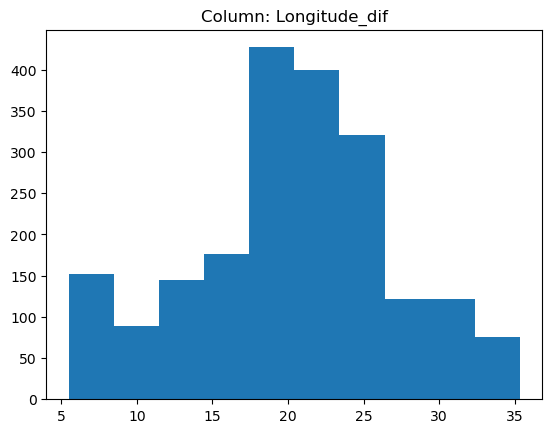

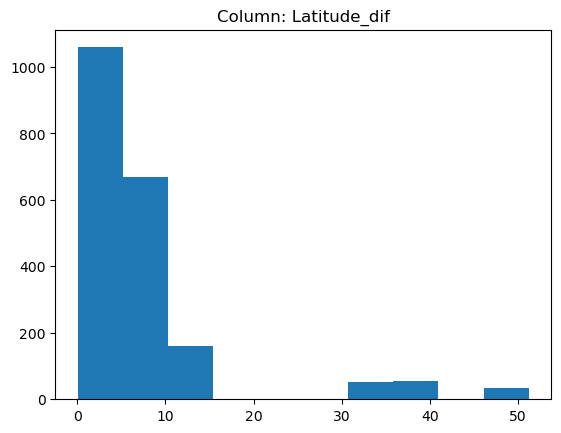

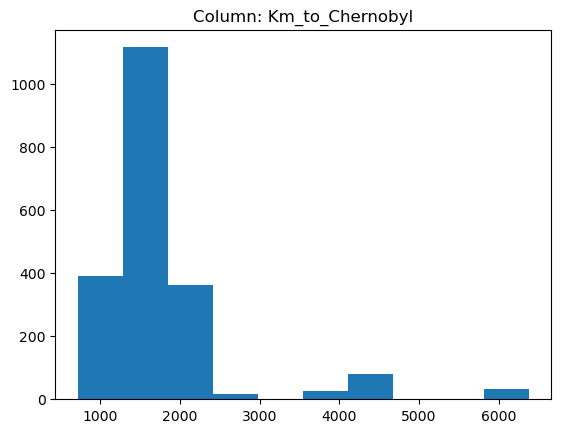

In [222]:
columns = ['Longitude_dif', 'Latitude_dif', 'Km_to_Chernobyl']

for column in columns:
    plt.title('Column: ' + column)
    plt.hist(df[column])
    plt.show()

In [223]:
df.head(10)

,Country,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137,Total_Radons,Km_to_Chernobyl,Longitude_dif,Latitude_dif
0,Sweden,RISOE,12.07,55.7,86/04/27,1.000000,0.000000,0.240000,1.240000,1312.348928,18.43,4.47
1,Sweden,RISOE,12.07,55.7,86/04/28,0.004600,0.000540,0.000980,0.006120,1312.348928,18.43,4.47
2,Sweden,RISOE,12.07,55.7,86/04/29,0.014700,0.004300,0.007400,0.026400,1312.348928,18.43,4.47
3,Sweden,RISOE,12.07,55.7,86/04/29,0.000610,0.000000,0.000090,0.000700,1312.348928,18.43,4.47
4,Sweden,RISOE,12.07,55.7,86/04/30,0.000750,0.000100,0.000280,0.001130,1312.348928,18.43,4.47
5,Sweden,RISOE,12.07,55.7,86/05/01,0.000530,0.000000,0.000200,0.000730,1312.348928,18.43,4.47
6,Sweden,RISOE,12.07,55.7,86/05/02,0.017600,0.000000,0.000220,0.017820,1312.348928,18.43,4.47
7,Sweden,RISOE,12.07,55.7,86/05/03,0.223900,0.002120,0.003560,0.229580,1312.348928,18.43,4.47
8,Sweden,RISOE,12.07,55.7,86/05/04,0.410000,0.014200,0.022700,0.446900,1312.348928,18.43,4.47
9,Sweden,RISOE,12.07,55.7,86/05/04,0.264303,0.014342,0.023966,0.302611,1312.348928,18.43,4.47


In [224]:
df = df.sort_values('Total_Radons', ascending = False)
df = df[(df['Total_Radons'] <= 40)]
df = df.loc[df.groupby(['Longitude_dif', 'Latitude_dif'])['Total_Radons'].idxmax()]
df.head(10)

,Country,Location,Longitude,Latitude,Date,Iodine_131,Caesium_134,Caesium_137,Total_Radons,Km_to_Chernobyl,Longitude_dif,Latitude_dif
1546,Finland,KONALA(Helsinki)NW,25.00,60.13,86/04/28,31.000,0.371369,0.553621,31.92499,1047.105667,5.50,8.90
1625,Finland,NURMIJAERVI,24.70,60.45,86/04/28,0.000,7.200000,11.900000,19.10000,1086.279614,5.80,9.22
986,Greece,ATTIKIS,23.78,38.00,86/05/05,13.500,0.000000,2.200000,15.70000,1562.684850,6.72,13.23
1030,Greece,THESSALONIKI,22.95,40.59,86/05/07,9.500,0.000000,0.000000,9.50000,1317.795954,7.55,10.64
1012,Greece,KOZANIS,21.79,40.31,86/05/04,11.000,0.000000,3.400000,14.40000,1387.292156,8.71,10.92
1956,Czechoslovakia,KOSICE,21.25,48.73,86/05/01,18.300,1.680000,2.720000,22.70000,716.816665,9.25,2.50
1875,Sweden,UMEAA,20.25,63.83,86/05/01,1.110,0.060000,0.102000,1.27200,1524.443862,10.25,12.60
2041,Hungary,BUDAPEST,19.10,47.50,86/05/02,4.100,0.800000,1.400000,6.30000,922.494504,11.40,3.73
1814,Sweden,STOCKHOLM,18.08,59.33,86/04/28,11.800,0.926000,1.620000,14.34600,1191.993174,12.42,8.10
835,Italy,TRISAIA,16.63,40.17,86/05/03,6.603,0.926000,2.037000,9.56600,1629.357335,13.87,11.06


In [225]:
idx = df.groupby(['Longitude', 'Latitude'])['Total_Radons'].idxmax()

# Seleccionar solo las filas correspondientes a los índices encontrados
df = df.loc[idx]
df.shape

(89, 12)

In [226]:
X = df[['Longitude_dif', 'Latitude_dif', 'Km_to_Chernobyl']].values
y = df[['Total_Radons']].values
X[0:10]

array([[3.53300000e+01, 4.77000000e+00, 2.36217751e+03],
       [3.49900000e+01, 4.77000000e+00, 2.34104738e+03],
       [3.41100000e+01, 3.83000000e+00, 2.29045911e+03],
       [3.29500000e+01, 4.60000000e-01, 2.26391452e+03],
       [3.24000000e+01, 1.68000000e+00, 2.28578733e+03],
       [3.18000000e+01, 3.90000000e-01, 2.18777409e+03],
       [3.09000000e+01, 1.17500000e+01, 2.71684360e+03],
       [3.05000000e+01, 5.12300000e+01, 6.37670604e+03],
       [3.02500000e+01, 4.08000000e+00, 2.22789064e+03],
       [2.89200000e+01, 3.52000000e+00, 2.11172700e+03]])

In [227]:
y[0:10]

array([[ 4.38      ],
       [ 0.07282483],
       [ 6.1       ],
       [ 3.12      ],
       [ 0.75      ],
       [ 6.31876507],
       [ 0.1411    ],
       [12.        ],
       [ 2.51      ],
       [ 0.76298411]])

In [228]:
#transform = preprocessing.StandardScaler()
#X = transform.fit(X).transform(X)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X[0:10]

array([[1.        , 0.09222352, 0.29070548],
       [0.98860208, 0.09222352, 0.28697217],
       [0.95910158, 0.07385698, 0.27803413],
       [0.92021455, 0.00801094, 0.27334419],
       [0.90177673, 0.03184838, 0.27720872],
       [0.88166276, 0.00664322, 0.25989155],
       [0.85149179, 0.22860492, 0.35336856],
       [0.83808247, 1.        , 1.        ],
       [0.82970164, 0.0787417 , 0.26697942],
       [0.78511566, 0.06779992, 0.24645541]])

## Regresion Lineal

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [230]:
kf = KFold(n_splits = 10, 
           shuffle = True,
           random_state = 1)

In [231]:
lr = LinearRegression(n_jobs = 3)

kfcv =  cross_validate(lr,
                       X_train, 
                       y_train,
                       return_train_score = True,
                       cv = kf)

In [232]:
print('Train scores: ', kfcv['train_score'])
print('Test scores: ', kfcv['test_score'])

Train scores:  [0.37748081 0.3319144  0.36417539 0.31256244 0.33235652 0.36360649
 0.33687184 0.33771693 0.326473   0.39472034]
Test scores:  [-0.66567065 -0.8901357  -0.84588093  0.58610595  0.46458574  0.09289783
  0.30778543 -1.39319066  0.56262384 -0.53711847]


In [233]:
print('Mean train score: ', np.abs(kfcv['train_score'].mean()))
print('Mean test score: ', np.abs(kfcv['test_score'].mean()))

Mean train score:  0.34778781537658315
Mean test score:  0.23179976247030262


In [234]:
print('Standard Deviation: ', kfcv['test_score'].mean(), '+-', kfcv['test_score'].std())

Standard Deviation:  -0.23179976247030262 +- 0.6798828033804395


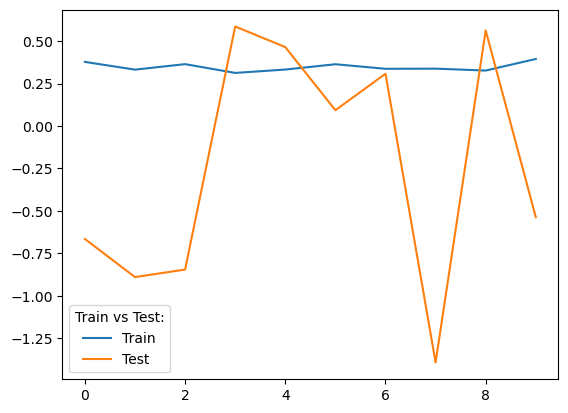

In [235]:
plt.plot(range(10), kfcv['train_score'], label = 'Train')
plt.plot(range(10), kfcv['test_score'], label = 'Test')
plt.legend(title = 'Train vs Test:')
plt.show()

In [236]:
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)
y_pred = lr.predict(X)

In [237]:
r2_test_lr = []
rmse_test_lr = []
mae_test_lr = []
r2_lr = []
rmse_lr = []
mae_lr = []

r2_test_lr.append(r2_score(y_test, y_pred_test))
rmse_test_lr.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
r2_lr.append(r2_score(y, y_pred))
rmse_lr.append(np.sqrt(mean_squared_error(y, y_pred)))
mae_test_lr.append(mean_absolute_error(y_test, y_pred_test))
mae_lr.append(mean_absolute_error(y, y_pred))

In [238]:
print('Test R2: ', r2_score(y_test, y_pred_test))
print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_test)))

Test R2:  0.19085601485213777
Test MAE:  7.293349146483025
Test RMSE:  9.294377010758396


In [239]:
lr_test_scores = pd.DataFrame({'Test R^2':r2_test_lr, 'Test RMSE':rmse_test_lr, 'Test MAE':mae_test_lr})
lr_scores = pd.DataFrame({'R^2':r2_lr, 'RMSE':rmse_lr, 'MAE':mae_lr})
lr_scores

,R^2,RMSE,MAE
0,0.299257,7.946496,5.907132


In [240]:
lr_test_scores

,Test R^2,Test RMSE,Test MAE
0,0.190856,9.294377,7.293349


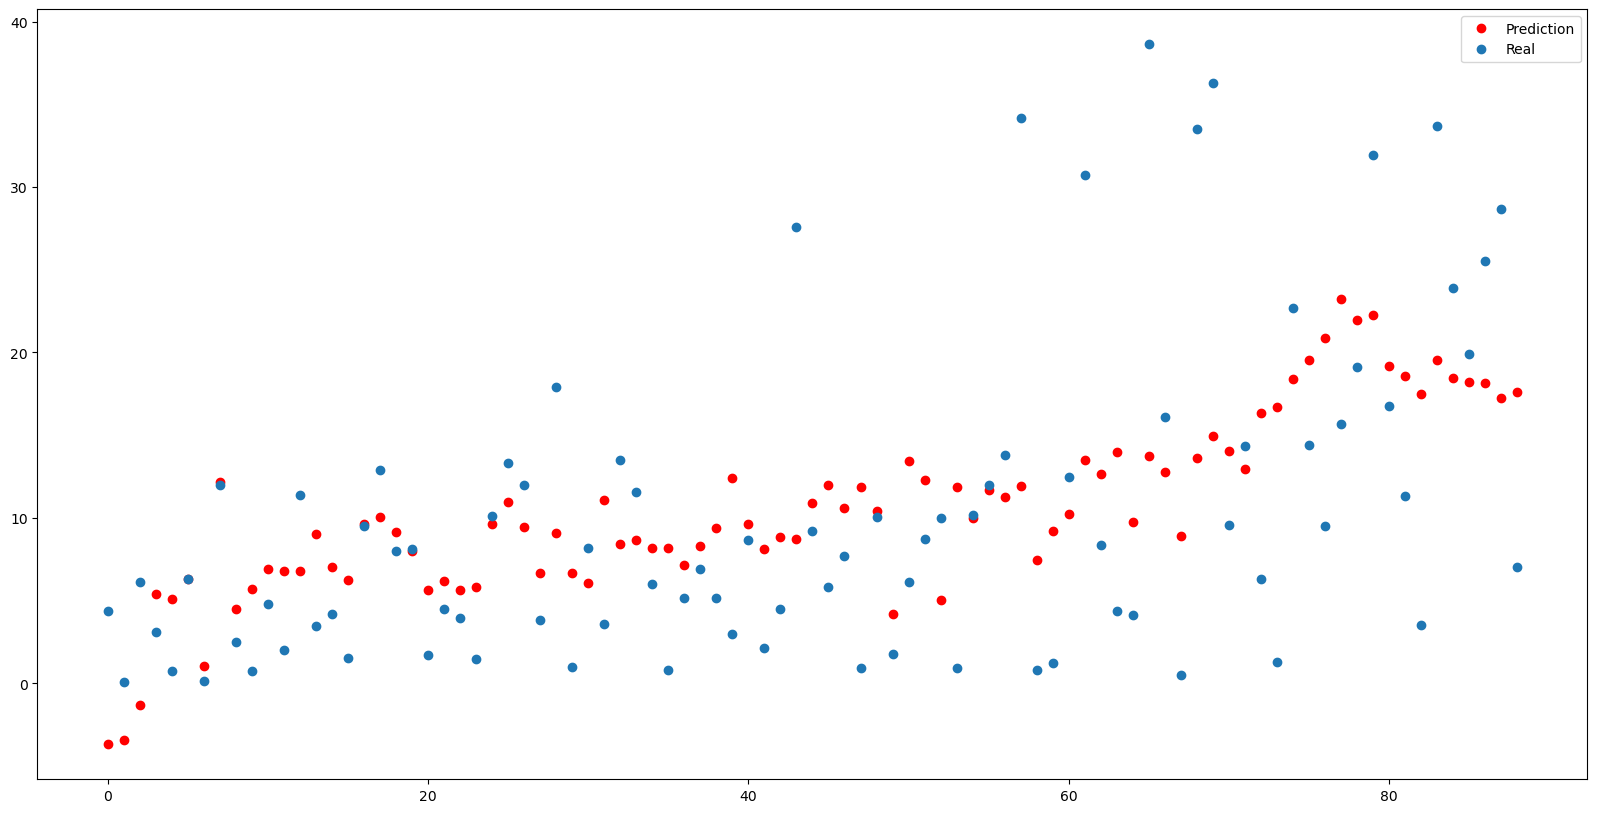

In [241]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(y_pred)), y_pred, 'ro', label = 'Prediction')
plt.plot(range(len(y)), y,'o', label = 'Real')
plt.legend()
plt.show()

In [242]:
param_grid = {'n_jobs': [2, 3, 4, -1]}

search = BayesSearchCV(estimator = lr,
                       search_spaces = param_grid,
                        cv = 3,
                        n_iter = 10,
                        scoring = 'r2',
                        random_state = 1,
                        refit = True)

search.fit(X_train, y_train)

print('Mejor combinación de hiperparámetros:', search.best_params_)
print('Mejor puntuación:', search.best_score_)

Mejor combinación de hiperparámetros: OrderedDict([('n_jobs', 3)])
Mejor puntuación: 0.20291452260162882


In [243]:
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001004,0.000819,0.000335,0.000474,3,{'n_jobs': 3},0.236175,-0.034028,0.406597,0.202915,0.181416,1
1,0.000670,0.000474,0.001003,0.000002,3,{'n_jobs': 3},0.236175,-0.034028,0.406597,0.202915,0.181416,1
2,0.000334,0.000472,0.000669,0.000473,3,{'n_jobs': 3},0.236175,-0.034028,0.406597,0.202915,0.181416,1
3,0.000669,0.000473,0.000335,0.000474,3,{'n_jobs': 3},0.236175,-0.034028,0.406597,0.202915,0.181416,1
4,0.000669,0.000473,0.000333,0.000472,4,{'n_jobs': 4},0.236175,-0.034028,0.406597,0.202915,0.181416,1


## Regresion polinomica

Polinomio grado  2
Train scores:  [0.42873628 0.42719446 0.40884507 0.39113494 0.39634951 0.40500558
 0.41419071 0.37607591 0.38664154 0.45252085]
Test scores:  [ -0.80803228 -51.31465854  -0.95816955   0.35555797   0.30317642
   0.17526347   0.11008811  -0.19887191   0.53264955  -0.51017748]
Mean train score:  0.4086694855977274
Mean test score:  5.231317421795131
Standard Deviation:  -5.231317421795131 +- 15.368614403354517
Test R2:  0.31312126205869817
Test MAE:  6.903031805182492
Test RMSE:  8.563423383258238
Mejor combinación de hiperparámetros: OrderedDict([('n_jobs', 3)])
Mejor puntuación: -0.41404471115490243
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_jobs  \
0       0.000669  4.730005e-04         0.000334        0.000473            3   
1       0.000669  4.731690e-04         0.000334        0.000473            3   
2       0.000669  4.729438e-04         0.000334        0.000472            3   
3       0.000669  4.731125e-04         0.000334        

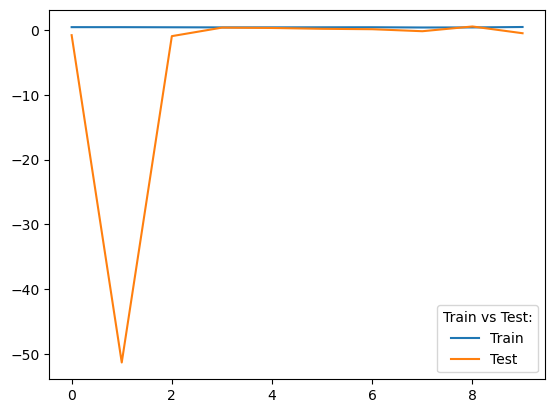

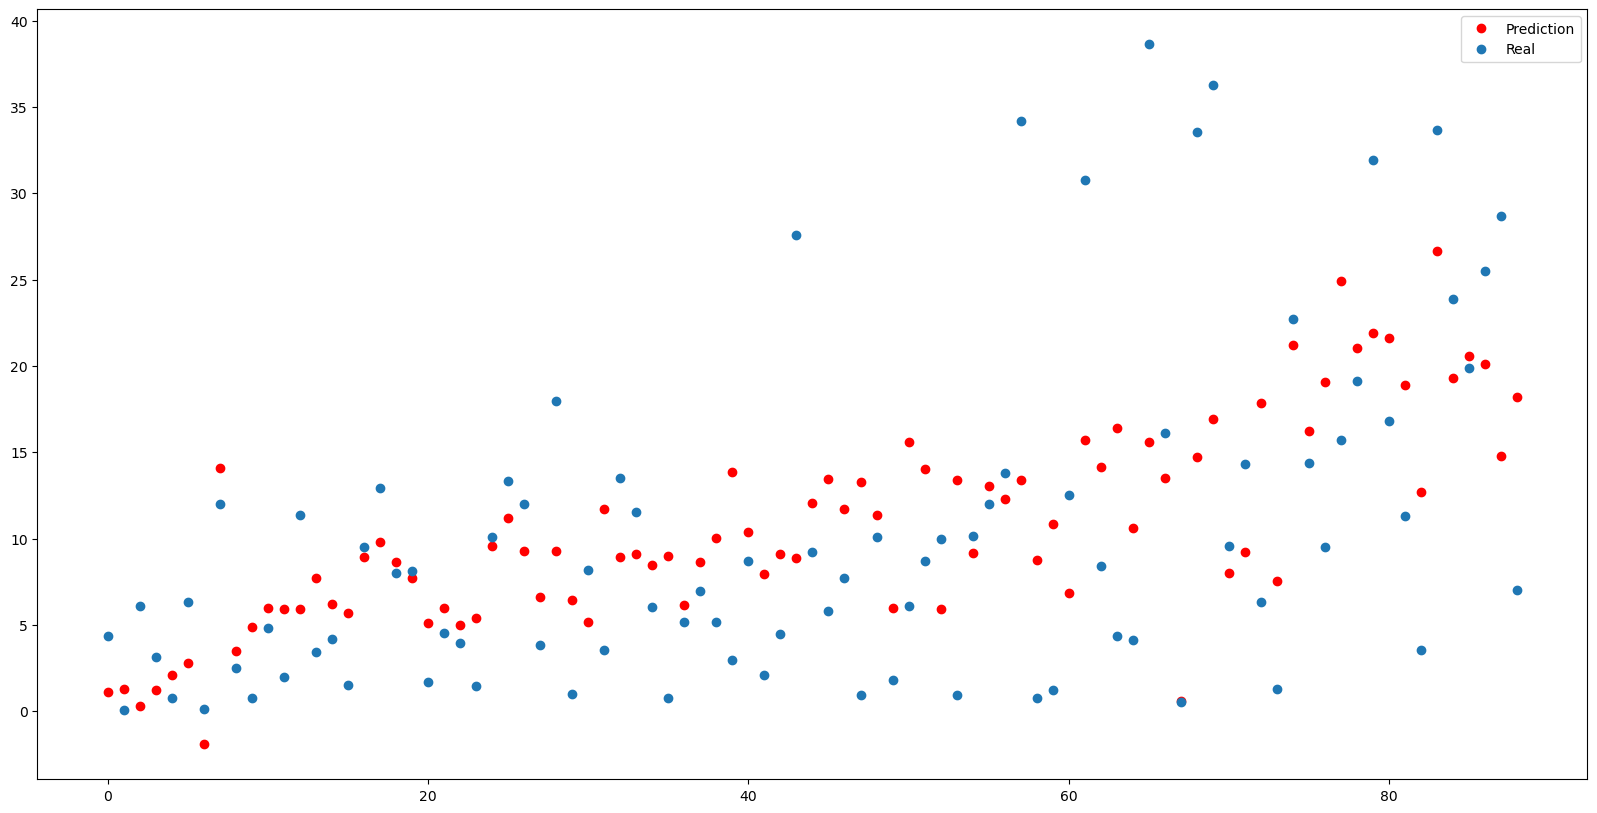

Polinomio grado  3
Train scores:  [0.54891991 0.51460145 0.52938735 0.57299861 0.52393296 0.57211748
 0.53030733 0.53841953 0.50376804 0.58346707]
Test scores:  [-1.41491612e+00 -1.10537417e+02 -1.17885476e+00 -2.94762881e-01
 -7.88457184e-01  2.87573685e-02  2.32505084e-01 -9.24875687e+01
  6.73863808e-01 -3.40307193e-01]
Mean train score:  0.5417919737153568
Mean test score:  20.610715773311824
Standard Deviation:  -20.610715773311824 +- 40.65609416972545
Test R2:  0.21790912737567547
Test MAE:  7.38820348883533
Test RMSE:  9.137680916329154
Mejor combinación de hiperparámetros: OrderedDict([('n_jobs', 3)])
Mejor puntuación: -21.788221951519272
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_jobs  \
0       0.000334      0.000472         0.000669        0.000473            3   
1       0.000669      0.000473         0.000669        0.000473            3   
2       0.000666      0.000471         0.000334        0.000473            3   
3       0.000668      0.0

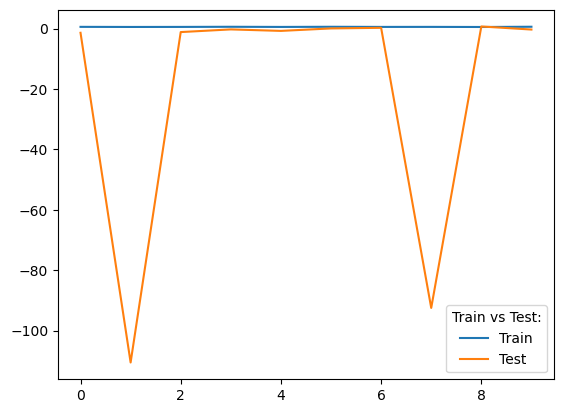

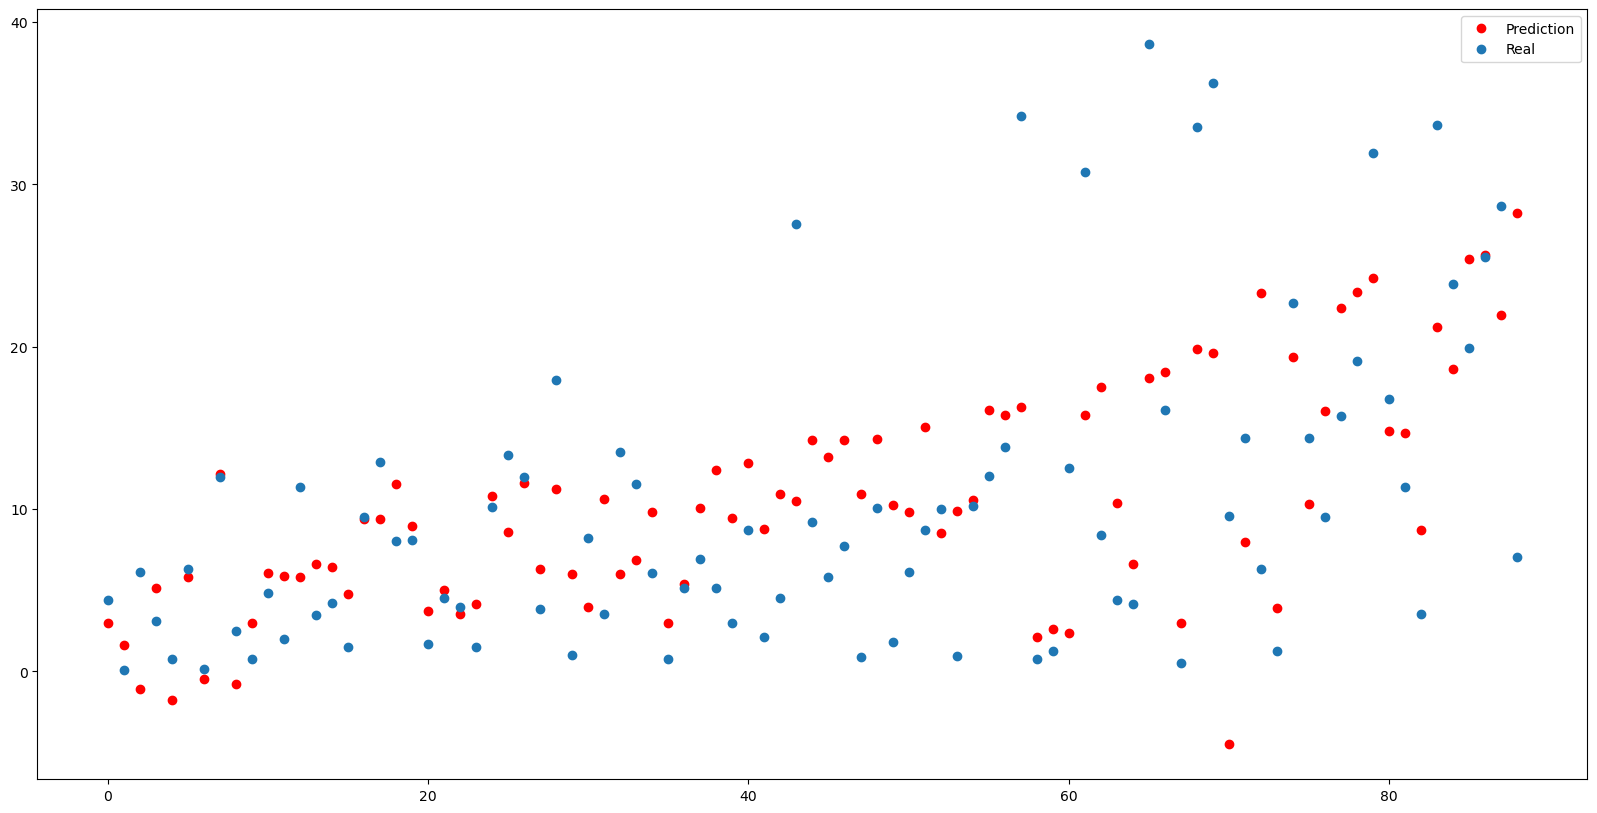

Polinomio grado  4
Train scores:  [ -5.98786778  -0.35989248   0.73371141   0.73674034 -14.49565778
   0.75124185   0.72883774  -0.66022546   0.74280238   0.85827355]
Test scores:  [-6.71279821e+01 -2.40882656e+05 -1.41232539e+01 -2.42093063e+00
 -8.93575638e+01  3.10508458e-01 -9.80075746e+01 -5.03533796e+02
 -1.64936256e+02 -6.09815598e-01]
Mean train score:  1.6952036227909968
Mean test score:  24182.246275889804
Standard Deviation:  -24182.246275889804 +- 72233.61178184391
Test R2:  -33.43385791293007
Test MAE:  28.816172688942608
Test RMSE:  60.63176648121087
Mejor combinación de hiperparámetros: OrderedDict([('n_jobs', 3)])
Mejor puntuación: -12354899.748987155
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_jobs  \
0       0.000669  4.731687e-04         0.000334        0.000473            3   
1       0.001003  4.899036e-07         0.000000        0.000000            3   
2       0.001004  9.081491e-06         0.000666        0.000471            3   
3   

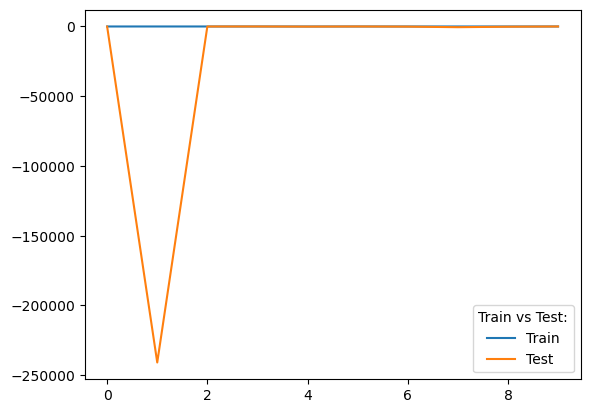

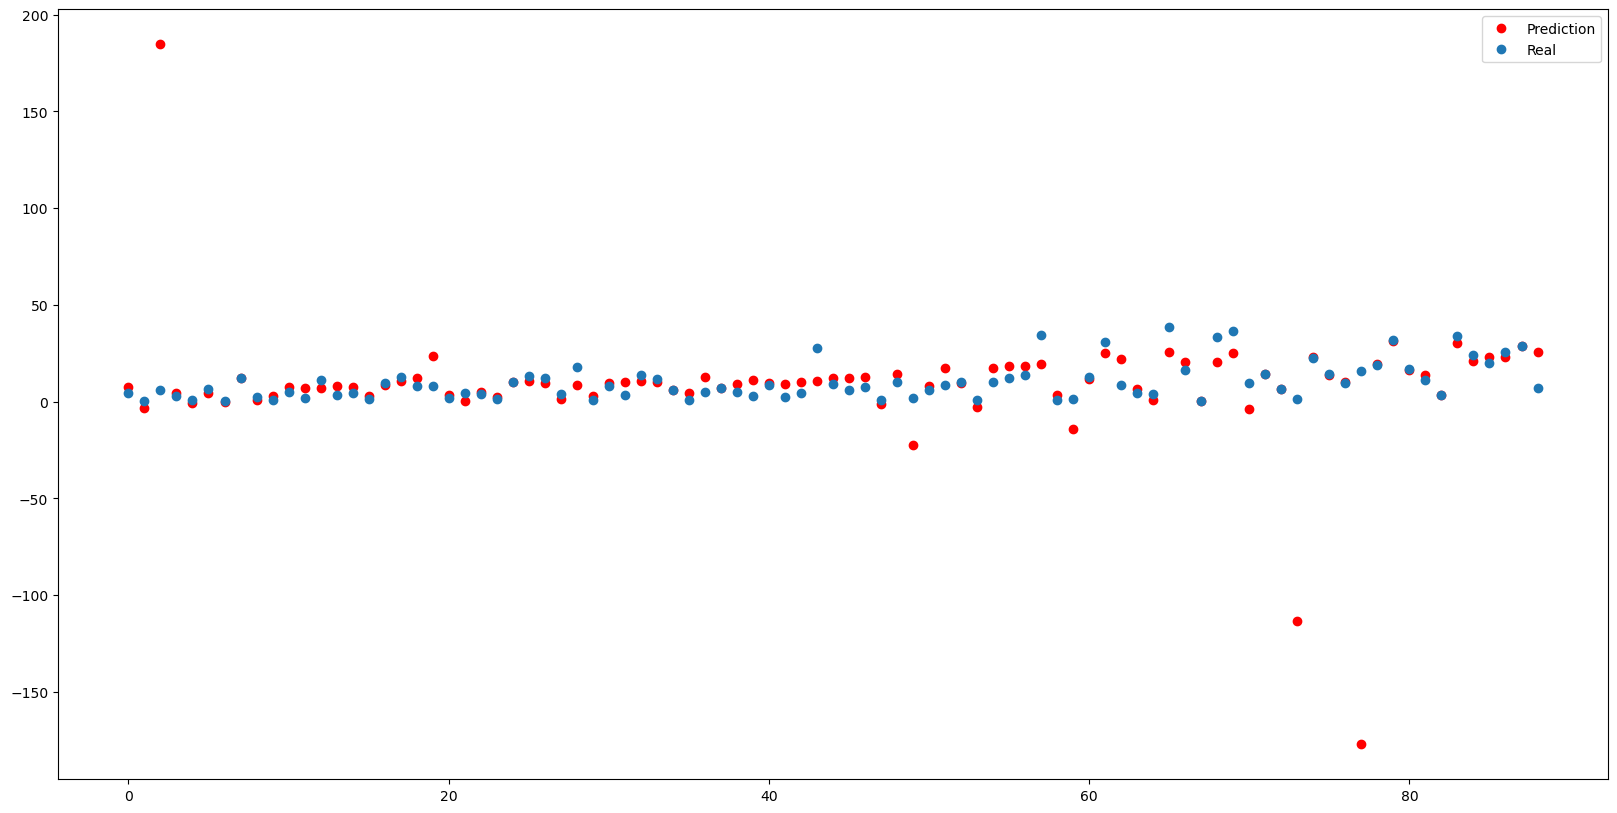

In [244]:
degrees = [i for i in range(2,5)]

r2_test_plr = []
rmse_test_plr = []
r2_plr = []
rmse_plr = []
mae_test_plr = []
mae_plr = []

param_grid = {'n_jobs': [2, 3, 4, -1]}

for d in degrees:
    poly = PolynomialFeatures(d)
    X_poly = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.25, random_state = 1)
    poly_reg = LinearRegression( n_jobs = 3)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 1)
    kfcv =  cross_validate(poly_reg, X_train, y_train, return_train_score = True, cv = kf)
    poly_reg.fit(X_train, y_train)
    y_pred_test = poly_reg.predict(X_test)
    y_pred = poly_reg.predict(X_poly)
    r2_test_plr.append(r2_score(y_test, y_pred_test))
    rmse_test_plr.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    r2_plr.append(r2_score(y, y_pred))
    rmse_plr.append(np.sqrt(mean_squared_error(y, y_pred)))
    mae_test_plr.append(mean_absolute_error(y_test, y_pred_test))
    mae_plr.append(mean_absolute_error(y, y_pred))
    search = BayesSearchCV(estimator = poly_reg,
                       search_spaces = param_grid,
                        cv = 3,
                        n_iter = 10,
                        scoring = 'r2',
                        random_state = 1,
                        refit = True)
    search.fit(X_train, y_train)
    results = pd.DataFrame(search.cv_results_)
    print('Polinomio grado ', d)
    print('Train scores: ', kfcv['train_score'])
    print('Test scores: ', kfcv['test_score'])
    print('Mean train score: ', np.abs(kfcv['train_score'].mean()))
    print('Mean test score: ', np.abs(kfcv['test_score'].mean()))
    print('Standard Deviation: ', kfcv['test_score'].mean(), '+-', kfcv['test_score'].std())
    print('Test R2: ', r2_score(y_test, y_pred_test))
    print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print('Mejor combinación de hiperparámetros:', search.best_params_)
    print('Mejor puntuación:', search.best_score_)
    print(results.head())
    plt.plot(range(10), kfcv['train_score'], label = 'Train')
    plt.plot(range(10), kfcv['test_score'], label = 'Test')
    plt.legend(title = 'Train vs Test:')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.plot(range(len(y_pred)), y_pred, 'ro', label = 'Prediction')
    plt.plot(range(len(y)), y, 'o', label = 'Real')
    plt.legend()
    plt.show()
    

In [245]:
plr_test_scores = pd.DataFrame({'degree':degrees, 'Test R^2':r2_test_plr, 'Test RMSE':rmse_test_plr, 'Test MAE':mae_test_plr})
plr_scores = pd.DataFrame({'degree':degrees, 'R^2':r2_plr, 'RMSE':rmse_plr, 'MAE':mae_plr})
plr_scores

,degree,R^2,RMSE,MAE
0,2,0.373909,7.511295,5.612428
1,3,0.429632,7.169249,5.359948
2,4,-9.727009,31.091057,9.743516


In [246]:
plr_test_scores

,degree,Test R^2,Test RMSE,Test MAE
0,2,0.313121,8.563423,6.903032
1,3,0.217909,9.137681,7.388203
2,4,-33.433858,60.631766,28.816173


## Ridge

alpha:  1
Train scores:  [0.29817554 0.23905233 0.28576743 0.24418758 0.24391384 0.27846433
 0.24836635 0.27489896 0.24988912 0.2925003 ]
Test scores:  [-0.52943868 -0.80752378 -0.78494812  0.37777139  0.44267506 -0.04032987
  0.25090848 -2.55846887  0.36050854 -0.55565532]
Mean train score:  0.26552157822803596
Mean test score:  0.3844501173702451
Standard Deviation:  -0.3844501173702451 +- 0.8636122262263021
Test R2:  0.15229516874040583
Test MAE:  7.23924411297132
Test RMSE:  9.513267507508882 



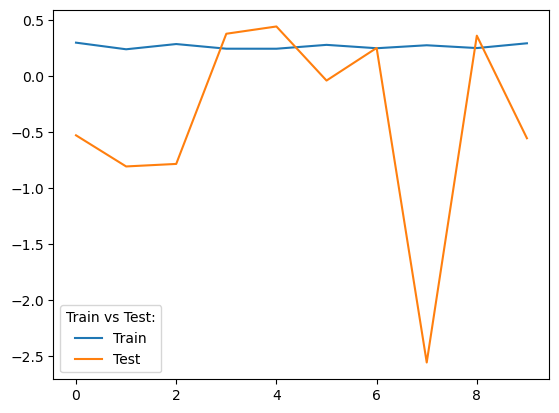

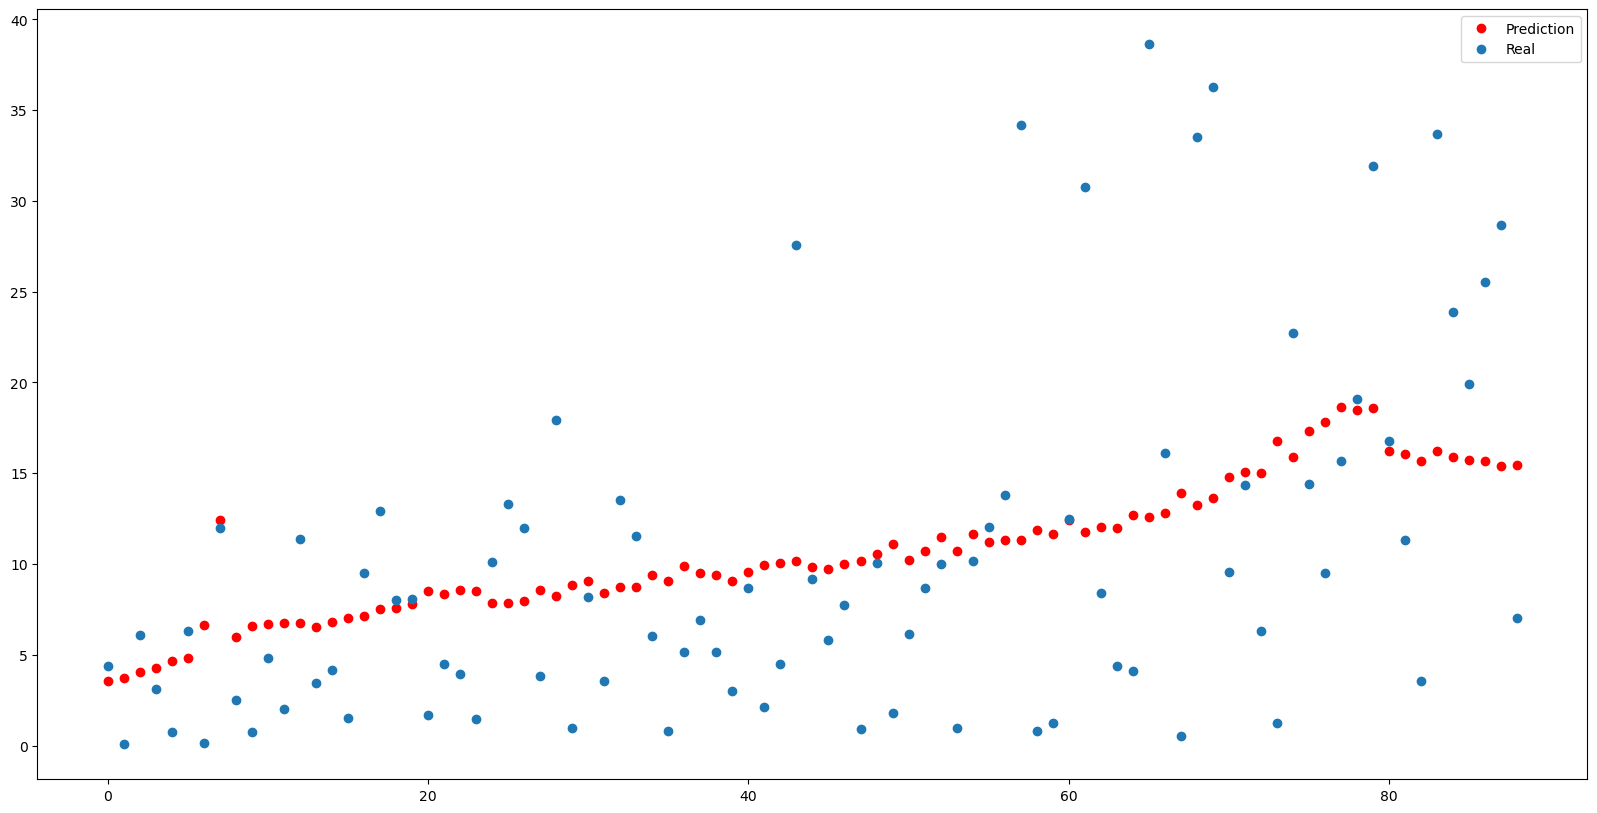

alpha:  0.1
Train scores:  [0.32877603 0.27121222 0.31702324 0.27196309 0.27486466 0.31118422
 0.28185072 0.30143887 0.27988985 0.33023364]
Test scores:  [-0.7541146  -0.45445857 -1.0218244   0.43965711  0.50331407  0.01945264
  0.29400157 -2.53115489  0.43896921 -0.51478756]
Mean train score:  0.29684365273809743
Mean test score:  0.35809454111099576
Standard Deviation:  -0.35809454111099576 +- 0.8907813171371116
Test R2:  0.16770558416806847
Test MAE:  7.345270687432141
Test RMSE:  9.426400121541644 



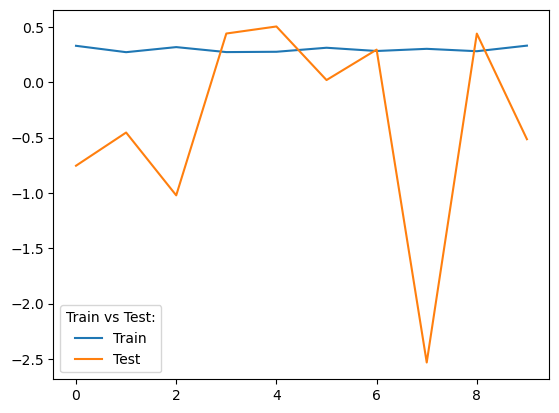

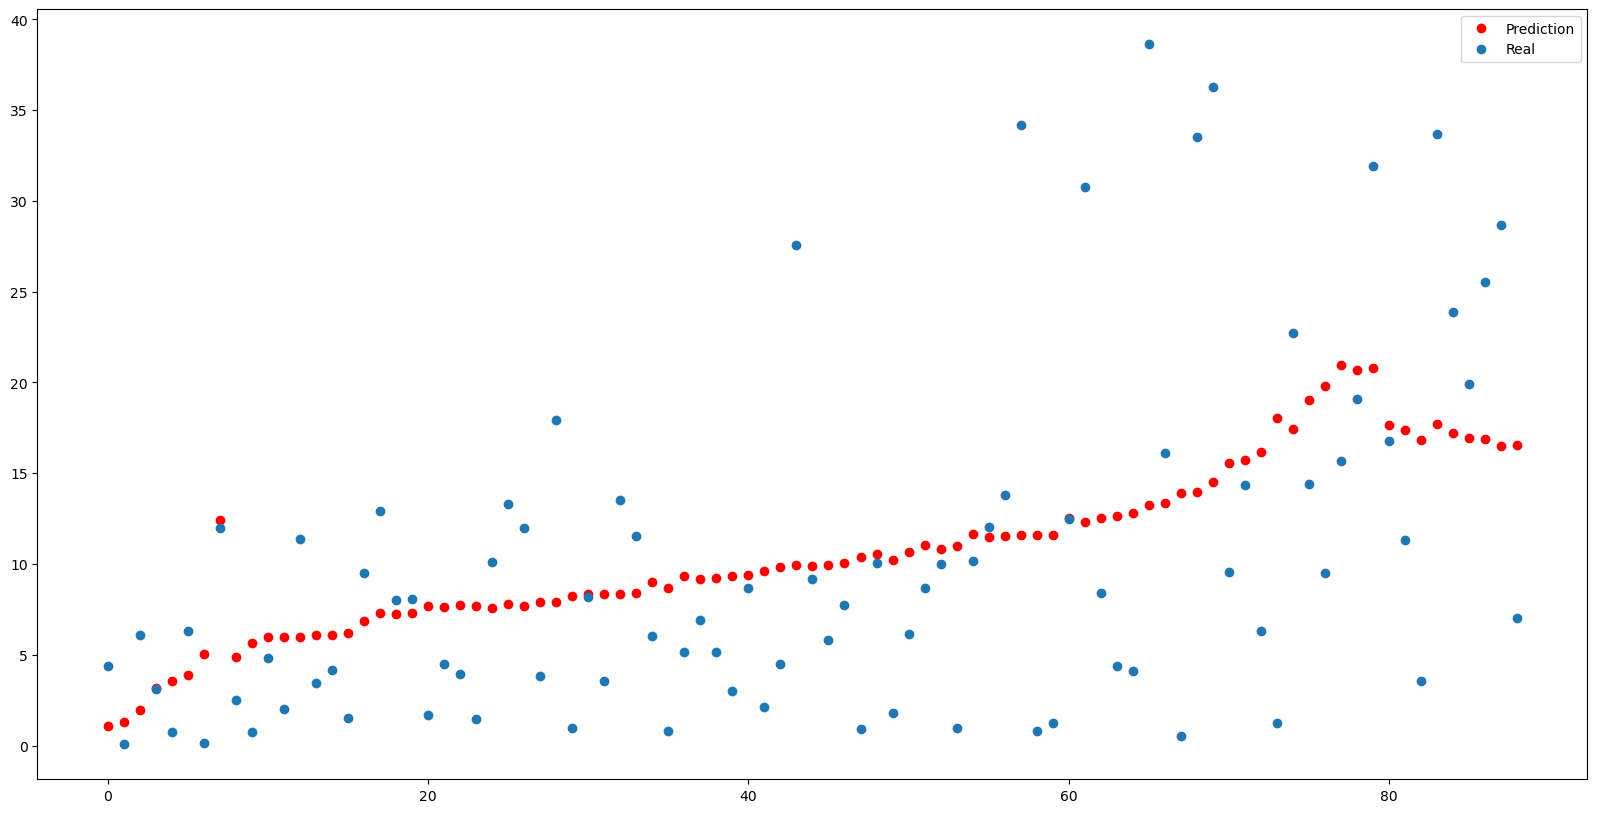

alpha:  0.01
Train scores:  [0.36756619 0.32046831 0.35536996 0.30458722 0.32038176 0.35452476
 0.32740546 0.33078305 0.31857654 0.38388445]
Test scores:  [-0.64320543 -0.57637237 -0.88199384  0.53640888  0.52830719  0.06639038
  0.30796393 -1.82324723  0.51745807 -0.52486362]
Mean train score:  0.33835477019155685
Mean test score:  0.2493154041048841
Standard Deviation:  -0.2493154041048841 +- 0.7372799556224524
Test R2:  0.19175367244553865
Test MAE:  7.308780082245295
Test RMSE:  9.289220027886653 



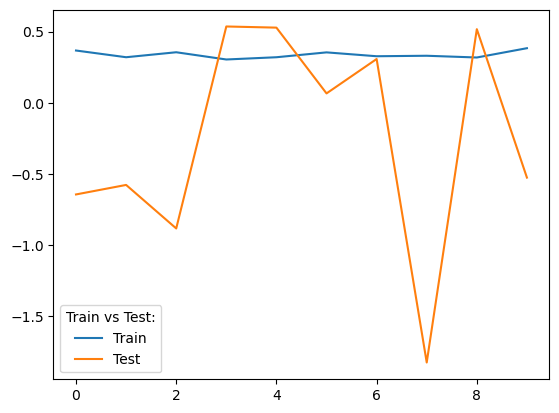

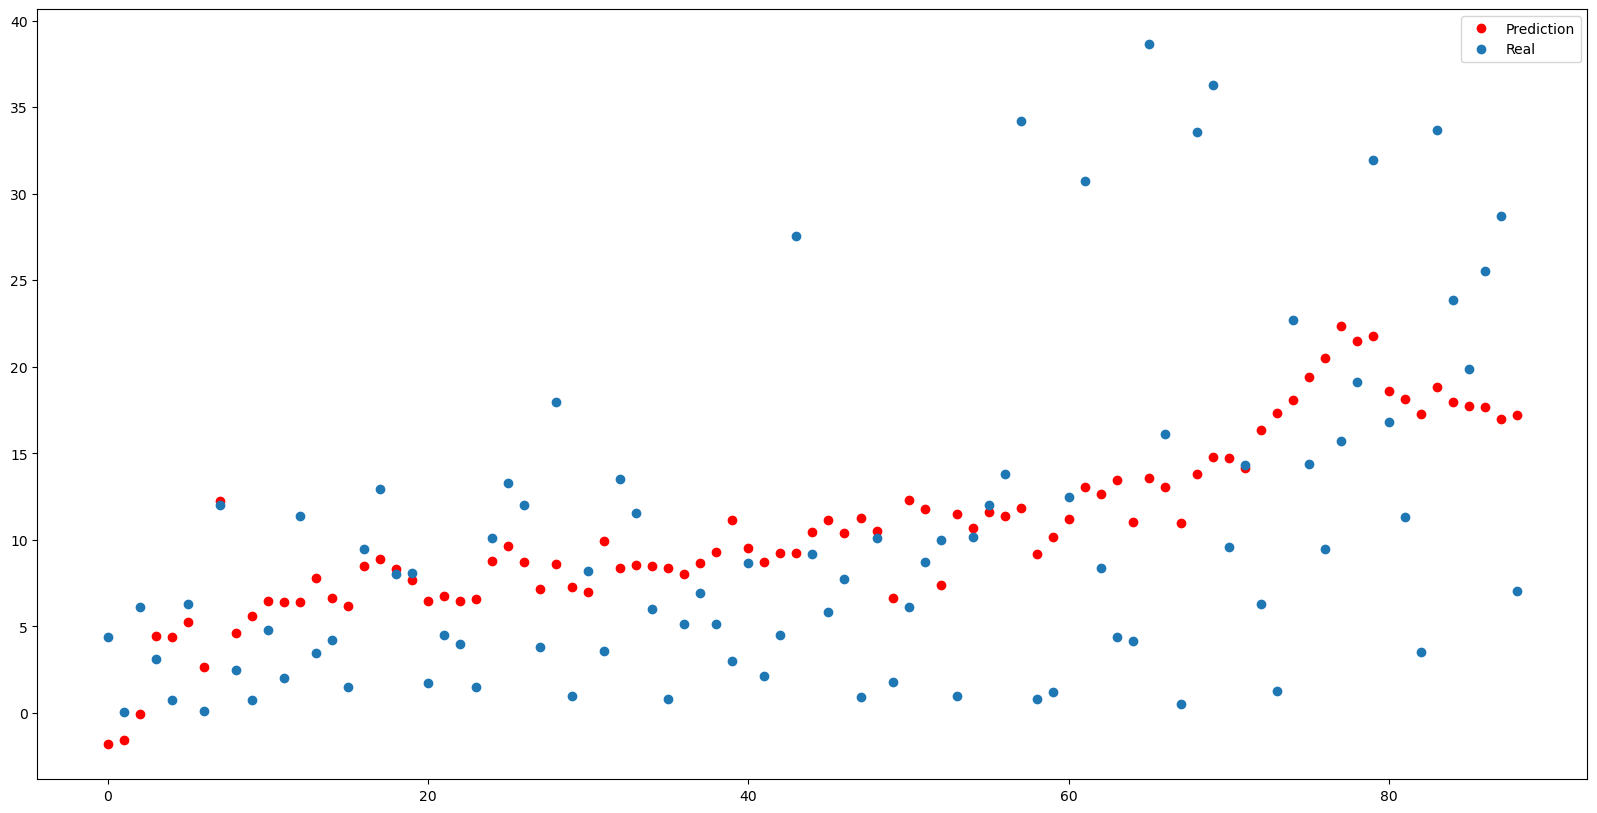

alpha:  0.001
Train scores:  [0.37724447 0.33165565 0.36397734 0.31237682 0.33206665 0.36341178
 0.33666976 0.33755845 0.3263059  0.39449237]
Test scores:  [-0.65391331 -0.83191936 -0.84591749  0.58008231  0.47953766  0.08923404
  0.30824574 -1.45013919  0.55641975 -0.53520557]
Mean train score:  0.3475759198694359
Mean test score:  0.2303575403410457
Standard Deviation:  -0.2303575403410457 +- 0.6835937757184429
Test R2:  0.19188338476677858
Test MAE:  7.288998862336021
Test RMSE:  9.288474602514084 



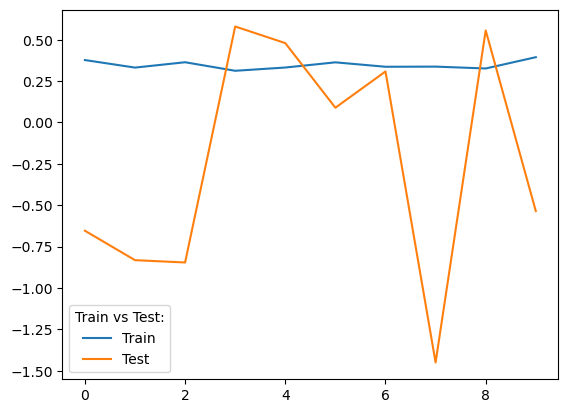

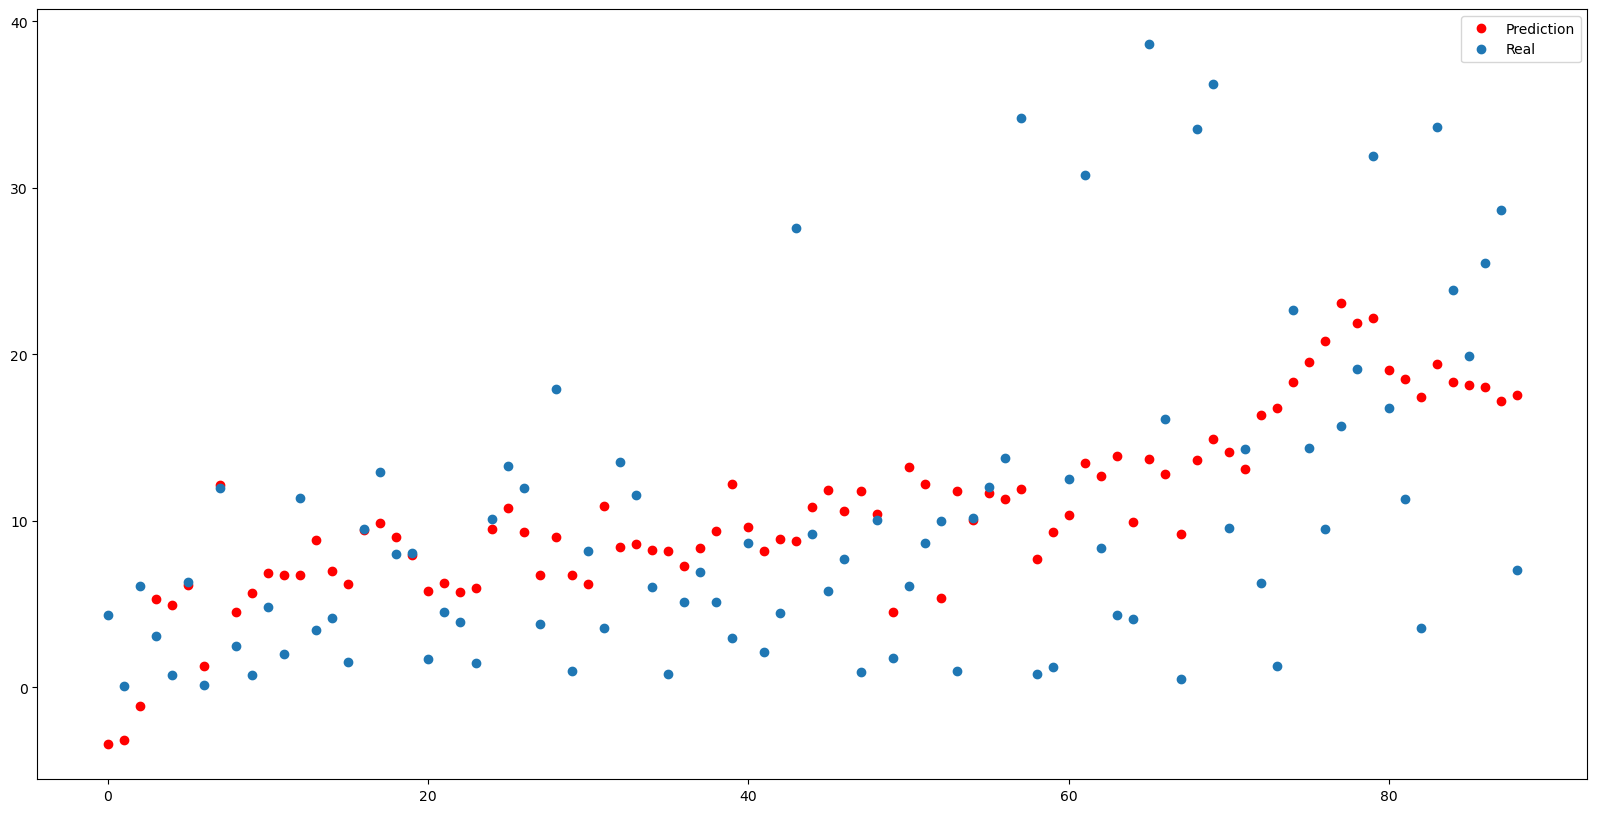

alpha:  0.0001
Train scores:  [0.37747817 0.33191153 0.3641732  0.31256037 0.33235327 0.36360435
 0.33686962 0.33771517 0.32647116 0.39471784]
Test scores:  [-0.66428232 -0.88382261 -0.84579366  0.58549663  0.46625678  0.09251695
  0.30784056 -1.39905583  0.56197957 -0.53691615]
Mean train score:  0.3477854672846084
Mean test score:  0.2315780068790473
Standard Deviation:  -0.2315780068790473 +- 0.6801823775653868
Test R2:  0.1909777844711913
Test MAE:  7.292894423560091
Test RMSE:  9.29367762019715 



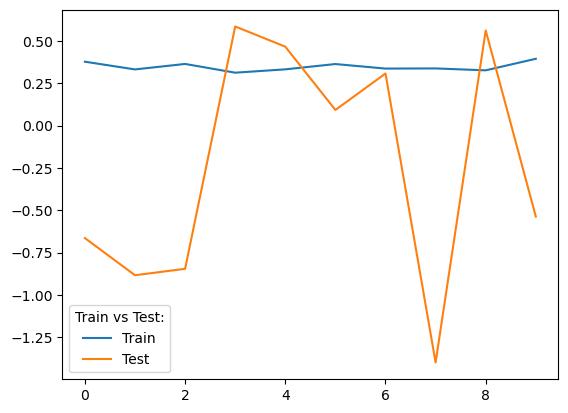

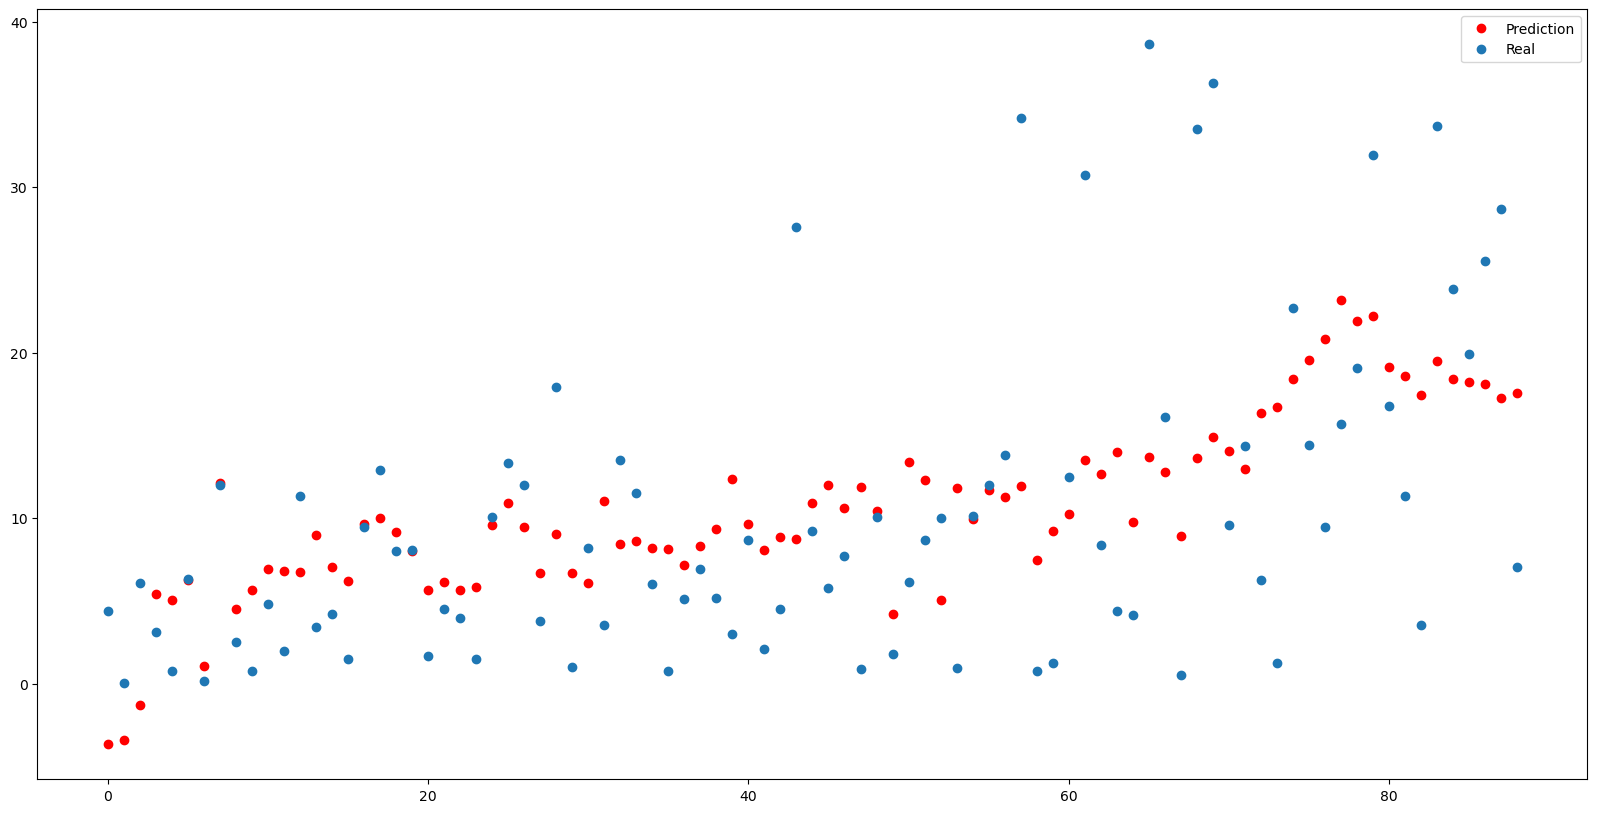

In [247]:
alphas = [1, 0.1, .01, 0.001, 0.0001]

r2_test_ridge = []
rmse_test_ridge = []
r2_ridge = []
rmse_ridge = []
mae_test_ridge = []
mae_ridge = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 1)
    kfcv =  cross_validate(ridge, X_train, y_train, return_train_score = True, cv = kf)
    ridge.fit(X_train, y_train)
    y_pred_test = ridge.predict(X_test)
    y_pred = ridge.predict(X)
    r2_test_ridge.append(r2_score(y_test, y_pred_test))
    rmse_test_ridge.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    r2_ridge.append(r2_score(y, y_pred))
    rmse_ridge.append(np.sqrt(mean_squared_error(y, y_pred)))
    mae_test_ridge.append(mean_absolute_error(y_test, y_pred_test))
    mae_ridge.append(mean_absolute_error(y, y_pred))
    print('alpha: ', alpha)
    print('Train scores: ', kfcv['train_score'])
    print('Test scores: ', kfcv['test_score'])
    print('Mean train score: ', np.abs(kfcv['train_score'].mean()))
    print('Mean test score: ', np.abs(kfcv['test_score'].mean()))
    print('Standard Deviation: ', kfcv['test_score'].mean(), '+-', kfcv['test_score'].std())
    print('Test R2: ', r2_score(y_test, y_pred_test))
    print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_test)), '\n')
    plt.plot(range(10), kfcv['train_score'], label = 'Train')
    plt.plot(range(10), kfcv['test_score'], label = 'Test')
    plt.legend(title = 'Train vs Test:')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.plot(range(len(y_pred)), y_pred, 'ro', label = 'Prediction')
    plt.plot(range(len(y)), y, 'o', label = 'Real')
    plt.legend()
    plt.show()


In [248]:
ridge_test_scores = pd.DataFrame({'alpha':alphas, 'Test R^2':r2_test_ridge, 'Test RMSE':rmse_test_ridge, 'Test MAE':mae_test_ridge})
ridge_scores = pd.DataFrame({'alpha':alphas, 'R^2':r2_ridge, 'RMSE':rmse_ridge, 'MAE':mae_ridge})
ridge_scores

,alpha,R^2,RMSE,MAE
0,1.0000,0.232484,8.316486,6.194519
1,0.1000,0.258217,8.175880,6.102745
2,0.0100,0.293889,7.976873,5.942874
3,0.0010,0.299453,7.945382,5.907408
4,0.0001,0.299293,7.946292,5.907147


In [249]:
ridge_test_scores

,alpha,Test R^2,Test RMSE,Test MAE
0,1.0000,0.152295,9.513268,7.239244
1,0.1000,0.167706,9.426400,7.345271
2,0.0100,0.191754,9.289220,7.308780
3,0.0010,0.191883,9.288475,7.288999
4,0.0001,0.190978,9.293678,7.292894


## Lasso

alpha:  1
Train scores:  [0.05392441 0.         0.02044547 0.         0.         0.
 0.01812284 0.01606944 0.0278332  0.01771601]
Test scores:  [-0.06210197 -2.9837218  -0.5679849  -0.00962402 -0.0287286  -0.2419442
 -0.05568761 -3.10165534 -0.02891244 -0.78799499]
Mean train score:  0.015411136256803048
Mean test score:  0.7868355869352447
Standard Deviation:  -0.7868355869352447 +- 1.155099598085609
Test R2:  -0.007993773233444745
Test MAE:  7.861251828335115
Test RMSE:  10.373762586564641 



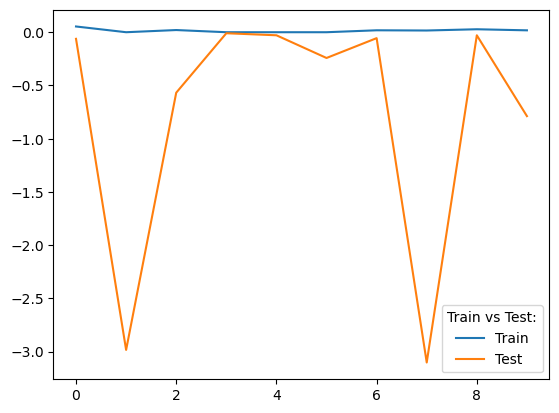

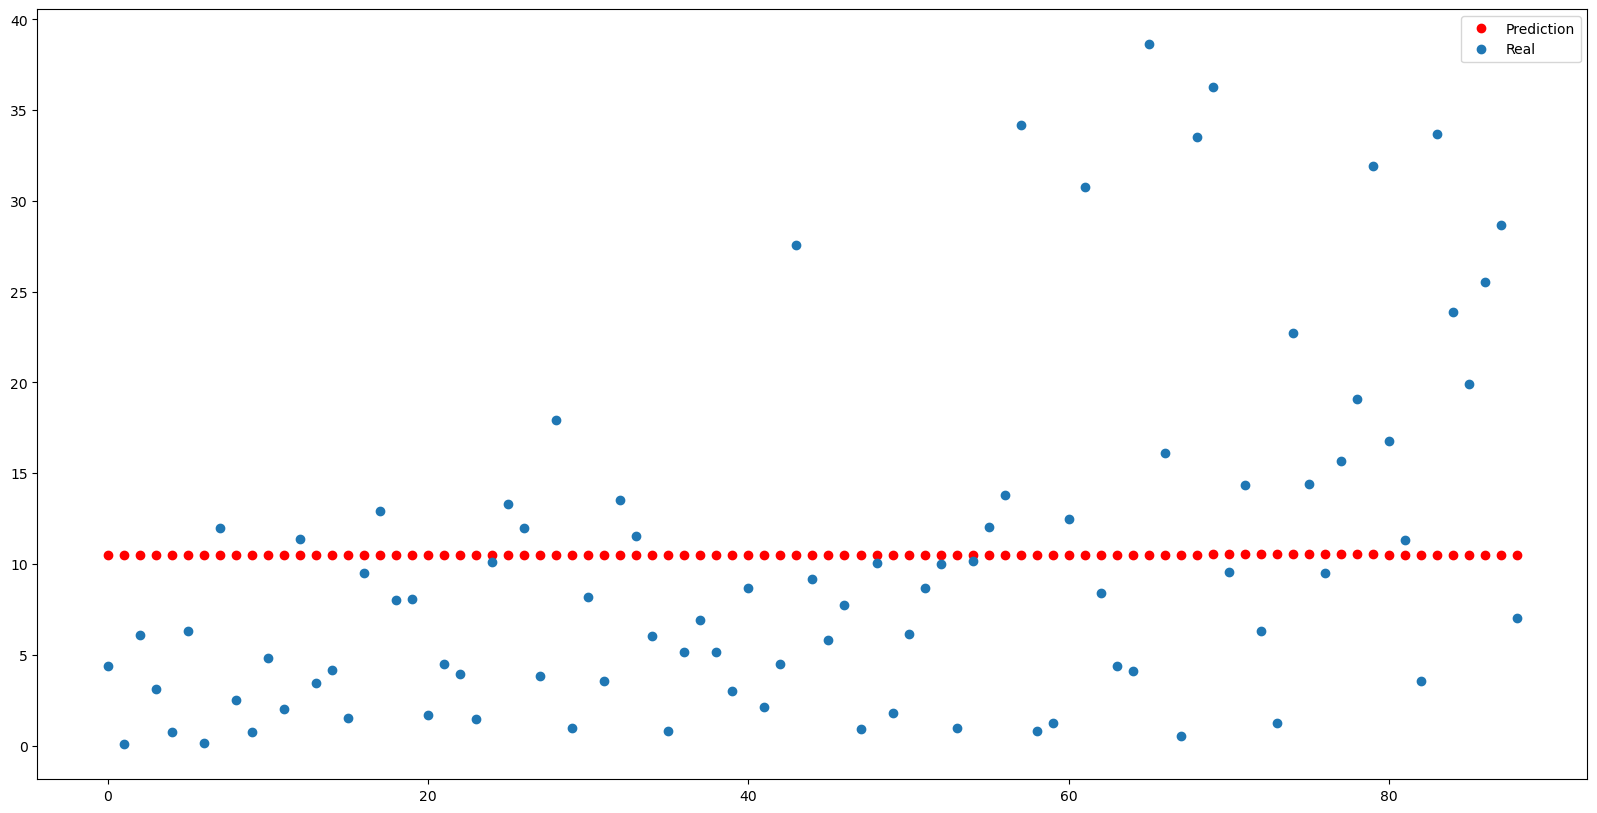

alpha:  0.1
Train scores:  [0.30938779 0.25488777 0.29472286 0.25409402 0.25270274 0.28346069
 0.25897546 0.28422569 0.25804516 0.31076348]
Test scores:  [-0.72959092 -0.58731319 -0.85392985  0.40015085  0.46696163  0.00454716
  0.16710468 -2.61342426  0.31861744 -0.53127721]
Mean train score:  0.27612656761964616
Mean test score:  0.3958153687666619
Standard Deviation:  -0.3958153687666619 +- 0.8751922802794104
Test R2:  0.14764601915054254
Test MAE:  7.394530256353495
Test RMSE:  9.539319103550255 



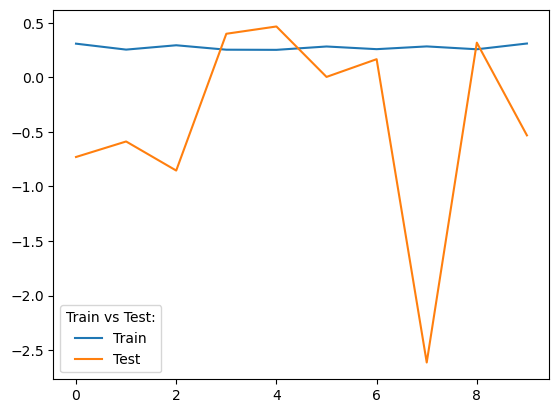

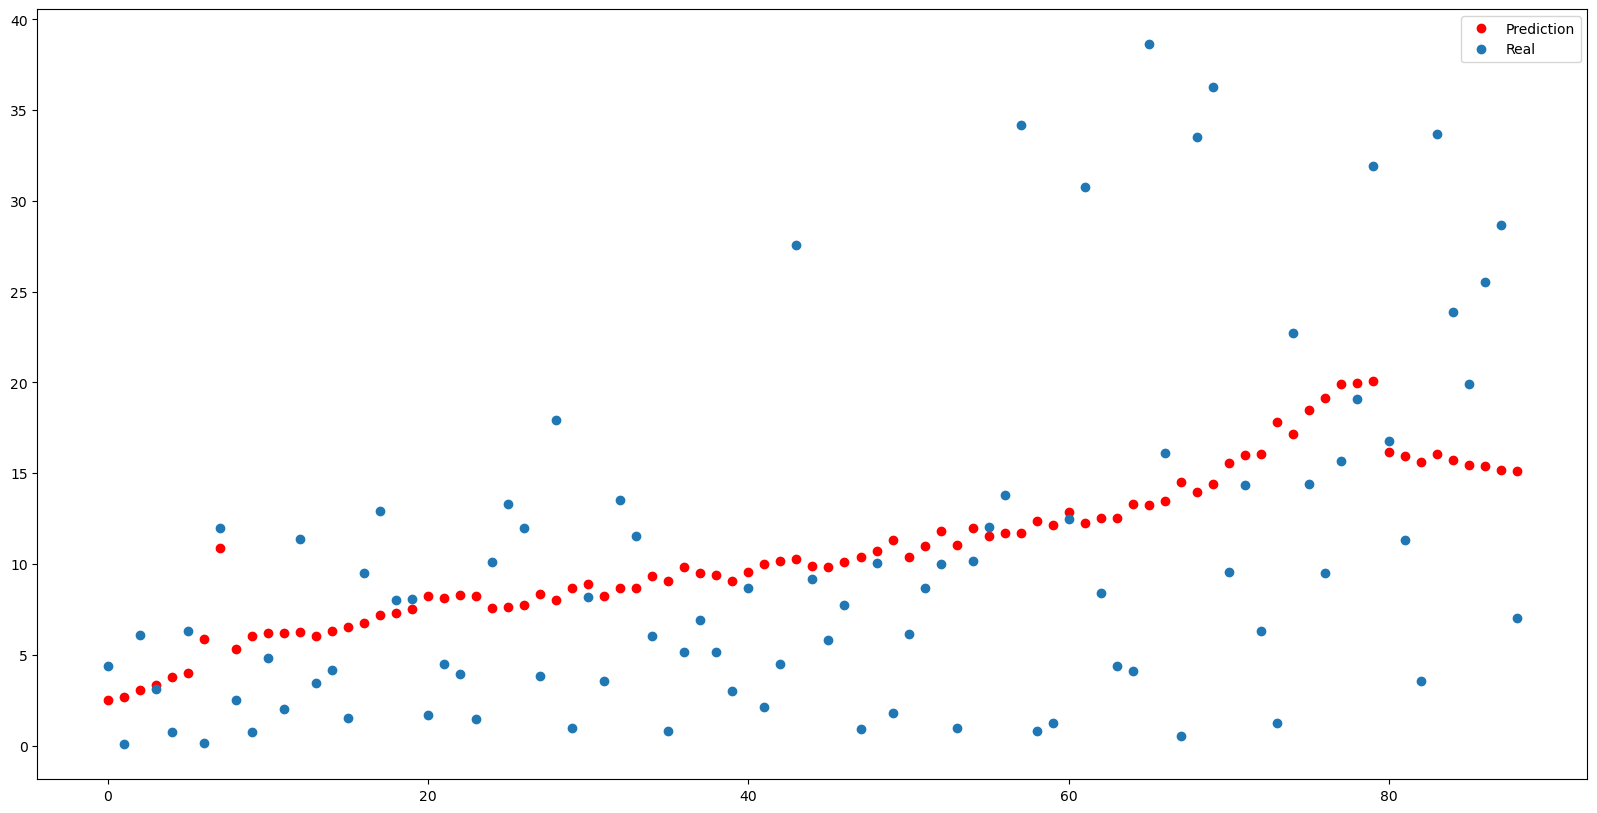

alpha:  0.01
Train scores:  [0.36636226 0.32130702 0.3539847  0.30084338 0.32042705 0.35140148
 0.32649539 0.32664474 0.31661693 0.3834497 ]
Test scores:  [-0.64389574 -0.58624554 -0.89240991  0.52290849  0.52849927  0.06058047
  0.30980049 -1.96112522  0.51312696 -0.52510836]
Mean train score:  0.336753264916391
Mean test score:  0.2673869106142493
Standard Deviation:  -0.2673869106142493 +- 0.7666266835189945
Test R2:  0.19080438115518794
Test MAE:  7.31051184784809
Test RMSE:  9.29467355587211 



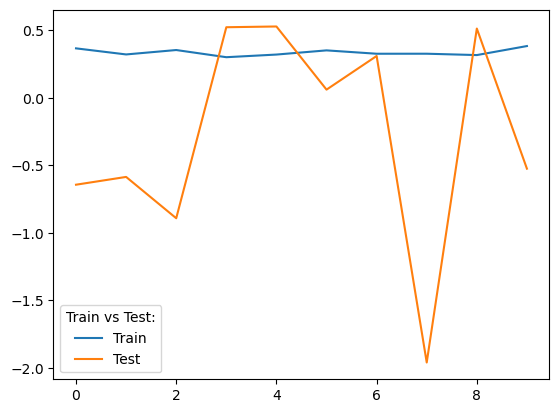

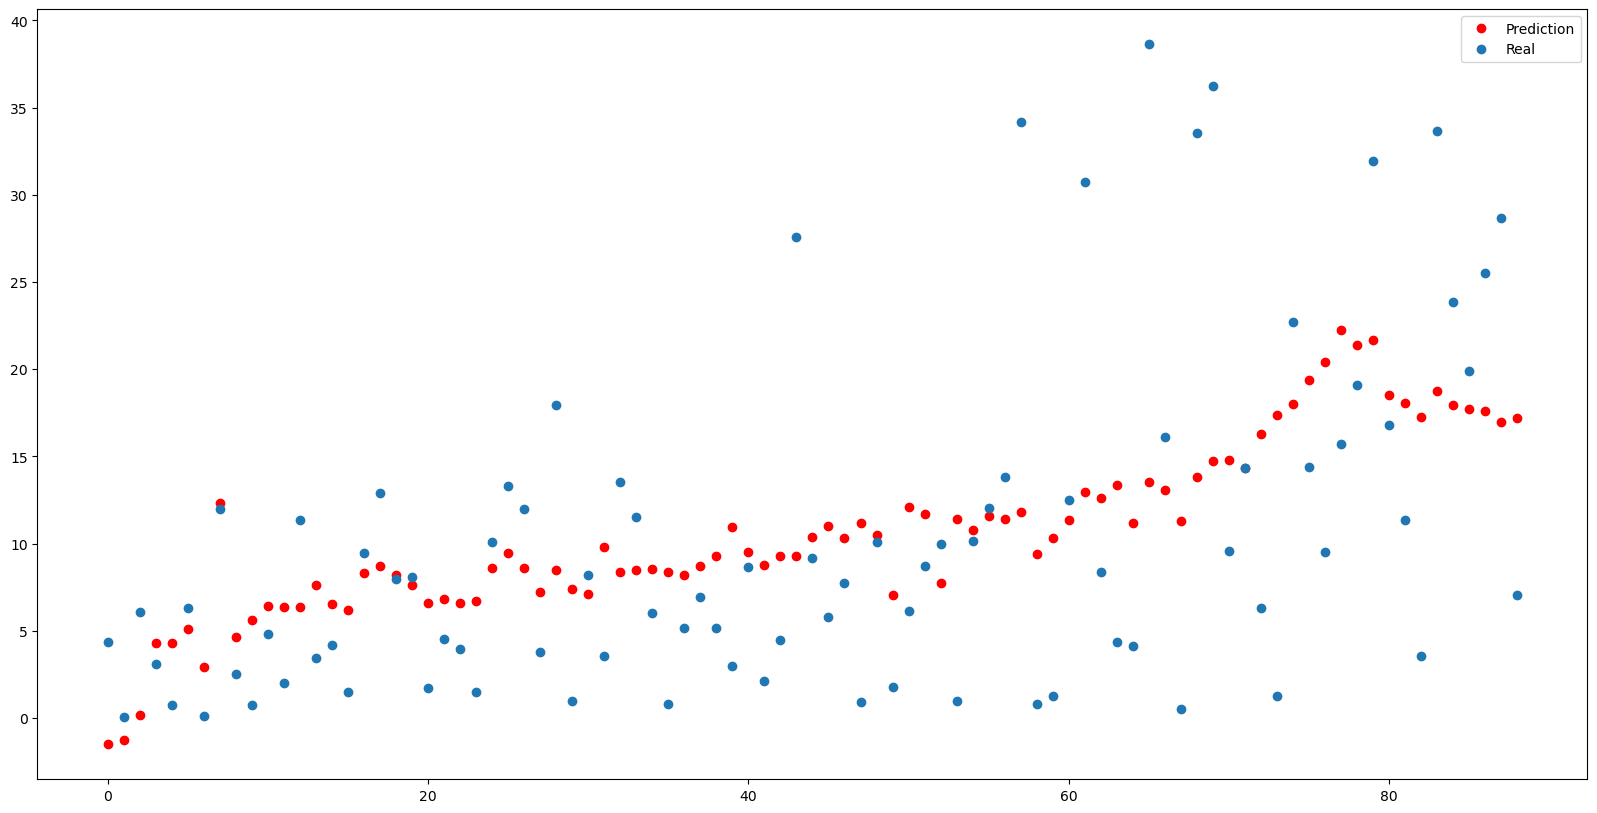

alpha:  0.001
Train scores:  [0.37736886 0.33180755 0.3640728  0.31244456 0.33223641 0.36348358
 0.33676734 0.33760556 0.32637379 0.39460673]
Test scores:  [-0.65687042 -0.85235087 -0.84606078  0.58139528  0.474462    0.089845
  0.30832158 -1.44102571  0.55796161 -0.53583082]
Mean train score:  0.3476767185379989
Mean test score:  0.2320153133925361
Standard Deviation:  -0.2320153133925361 +- 0.6838675632557616
Test R2:  0.19172604863349219
Test MAE:  7.289568099130963
Test RMSE:  9.289378767535002 



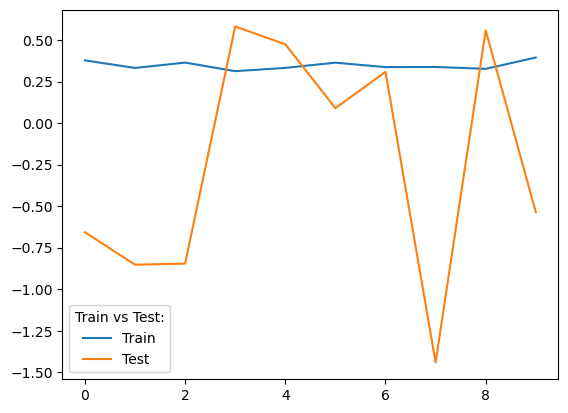

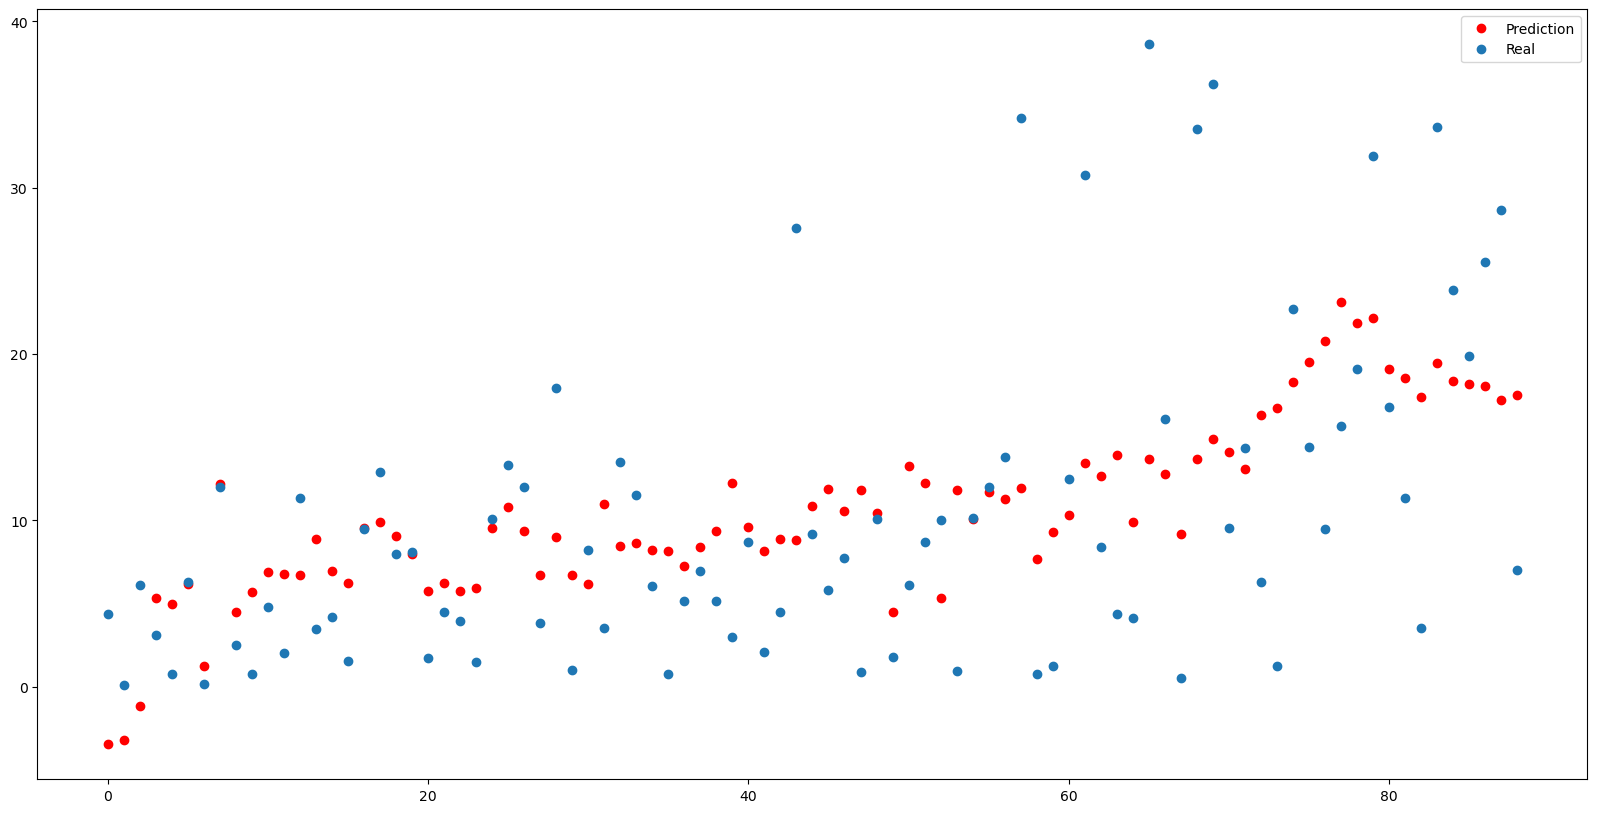

alpha:  0.0001
Train scores:  [0.37747969 0.33191333 0.36417437 0.31256126 0.33235532 0.36360526
 0.33687079 0.33771581 0.326472   0.3947192 ]
Test scores:  [-0.66472341 -0.88628072 -0.84585398  0.58565086  0.46560911  0.09259414
  0.30784251 -1.39788666  0.56216033 -0.53698875]
Mean train score:  0.34778670240630716
Mean test score:  0.23178765882586339
Standard Deviation:  -0.23178765882586339 +- 0.680231743522705
Test R2:  0.1909518889408508
Test MAE:  7.292970655927607
Test RMSE:  9.293826357018201 



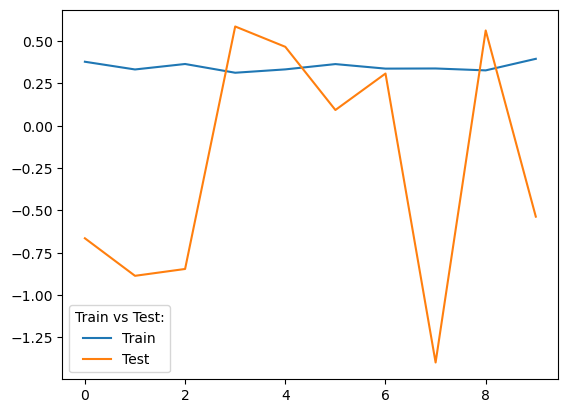

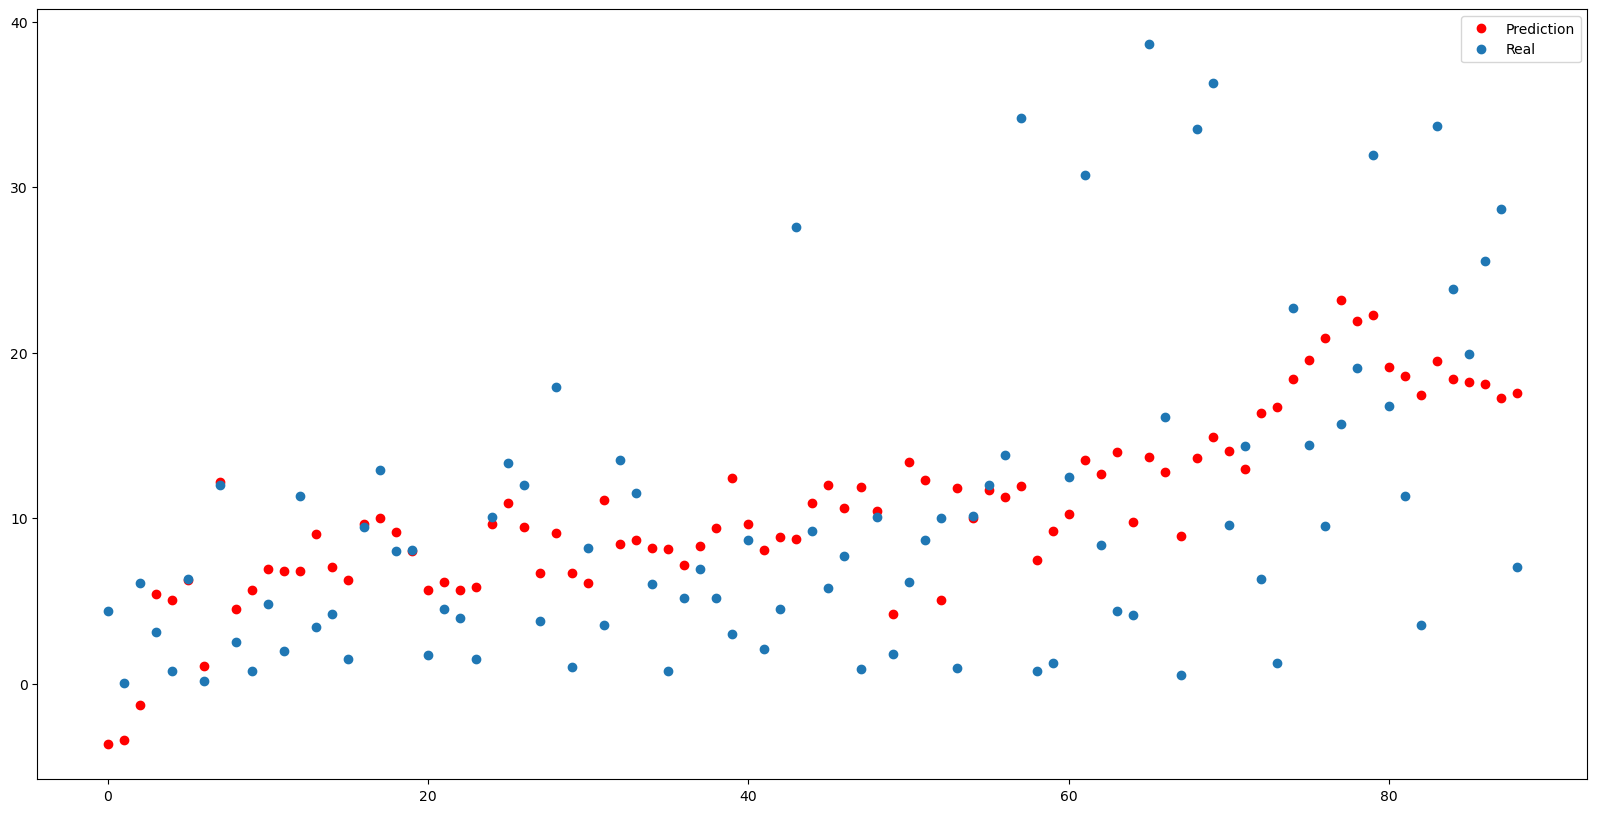

In [250]:
alphas = [1, 0.1, .01, 0.001, 0.0001]

r2_test_lasso = []
rmse_test_lasso = []
r2_lasso = []
rmse_lasso = []
mae_test_lasso = []
mae_lasso = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 1)
    kfcv =  cross_validate(lasso, X_train, y_train, return_train_score = True, cv = kf)
    lasso.fit(X_train, y_train)
    y_pred_test = lasso.predict(X_test)
    y_pred = lasso.predict(X)
    r2_test_lasso.append(r2_score(y_test, y_pred_test))
    rmse_test_lasso.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    r2_lasso.append(r2_score(y, y_pred))
    rmse_lasso.append(np.sqrt(mean_squared_error(y, y_pred)))
    mae_test_lasso.append(mean_absolute_error(y_test, y_pred_test))
    mae_lasso.append(mean_absolute_error(y, y_pred))
    print('alpha: ', alpha)
    print('Train scores: ', kfcv['train_score'])
    print('Test scores: ', kfcv['test_score'])
    print('Mean train score: ', np.abs(kfcv['train_score'].mean()))
    print('Mean test score: ', np.abs(kfcv['test_score'].mean()))
    print('Standard Deviation: ', kfcv['test_score'].mean(), '+-', kfcv['test_score'].std())
    print('Test R2: ', r2_score(y_test, y_pred_test))
    print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_test)), '\n')
    plt.plot(range(10), kfcv['train_score'], label = 'Train')
    plt.plot(range(10), kfcv['test_score'], label = 'Test')
    plt.legend(title = 'Train vs Test:')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.plot(range(len(y_pred)), y_pred, 'ro', label = 'Prediction')
    plt.plot(range(len(y)), y, 'o', label = 'Real')
    plt.legend()
    plt.show()

In [251]:
lasso_test_scores = pd.DataFrame({'alpha':alphas, 'Test R^2':r2_test_lasso, 'Test RMSE':rmse_test_lasso, 'Test MAE':mae_test_lasso})
lasso_scores = pd.DataFrame({'alpha':alphas, 'R^2':r2_lasso, 'RMSE':rmse_lasso, 'MAE':mae_lasso})
lasso_scores

,alpha,R^2,RMSE,MAE
0,1.0000,0.000885,9.488636,7.265298
1,0.1000,0.235181,8.301863,6.246379
2,0.0100,0.291720,7.989117,5.949015
3,0.0010,0.299447,7.945415,5.907212
4,0.0001,0.299285,7.946334,5.907140


In [252]:
lasso_test_scores

,alpha,Test R^2,Test RMSE,Test MAE
0,1.0000,-0.007994,10.373763,7.861252
1,0.1000,0.147646,9.539319,7.394530
2,0.0100,0.190804,9.294674,7.310512
3,0.0010,0.191726,9.289379,7.289568
4,0.0001,0.190952,9.293826,7.292971


## Arbol de decision

In [253]:
r2_test_dt = []
rmse_test_dt = []
r2_dt = []
rmse_dt = []
mae_test_dt = []
mae_dt = []

param_grid = {'max_depth': Integer(1, 10),
              'min_samples_split': Integer(2, 20),
              'min_samples_leaf': Integer(1, 10),
              'max_features': ['auto', 'sqrt', 'log2']}

dt = DecisionTreeRegressor(max_depth = 7,
                            max_features = 'auto',
                            min_samples_leaf= 4,
                            min_samples_split = 5)

kf = KFold(n_splits = 10, 
           shuffle = True,
           random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

kfcv =  cross_validate(dt,
                       X_train, 
                       y_train,
                       return_train_score = True,
                       cv = kf)

dt.fit(X_train, y_train)
y_pred_test = dt.predict(X_test)
y_pred = lr.predict(X)

search = BayesSearchCV(estimator = dt,
                       search_spaces = param_grid,
                        cv = 3,
                        n_iter = 10,
                        scoring = 'r2',
                        random_state = 1,
                        refit = True)

search.fit(X_train, y_train)


BayesSearchCV(cv=3,
              estimator=DecisionTreeRegressor(max_depth=7, max_features='auto',
                                              min_samples_leaf=4,
                                              min_samples_split=5),
              n_iter=10, random_state=1, scoring='r2',
              search_spaces={'max_depth': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'max_features': ['auto', 'sqrt', 'log2'],
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize')})

In [254]:
print('Train scores: ', kfcv['train_score'])
print('Test scores: ', kfcv['test_score'])
print('Mean train score: ', np.abs(kfcv['train_score'].mean()))
print('Mean test score: ', np.abs(kfcv['test_score'].mean()))
print('Standard Deviation: ', kfcv['test_score'].mean(), '+-', kfcv['test_score'].std())
print('Test R2: ', r2_score(y_test, y_pred_test))
print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_test)), '\n')
print('Mejor combinación de hiperparámetros:', search.best_params_)
print('Mejor puntuación:', search.best_score_)

Train scores:  [0.64084806 0.74103989 0.62157777 0.64029403 0.64791648 0.59415864
 0.5502612  0.63689277 0.64790121 0.66072513]
Test scores:  [-0.13627313 -7.91169342  0.07265807  0.18749823  0.16760551 -0.40558489
  0.0264515  -1.62461559  0.18842312 -0.6938321 ]
Mean train score:  0.6381615178545142
Mean test score:  1.0129362708268677
Standard Deviation:  -1.0129362708268677 +- 2.3609970678826326
Test R2:  0.29229308865382375
Test MAE:  6.1005072719425915
Test RMSE:  8.692287820290005 

Mejor combinación de hiperparámetros: OrderedDict([('max_depth', 8), ('max_features', 'auto'), ('min_samples_leaf', 8), ('min_samples_split', 7)])
Mejor puntuación: 0.18854955811545623


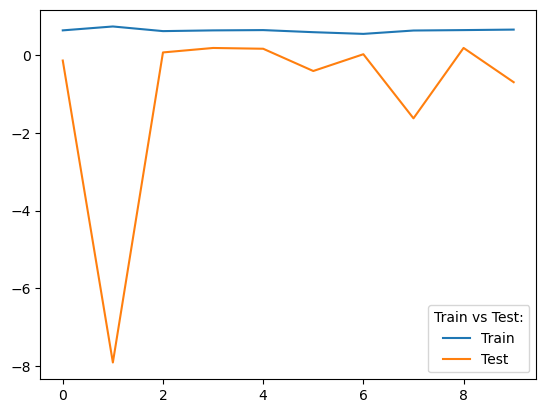

In [255]:
plt.plot(range(10), kfcv['train_score'], label = 'Train')
plt.plot(range(10), kfcv['test_score'], label = 'Test')
plt.legend(title = 'Train vs Test:')
plt.show()

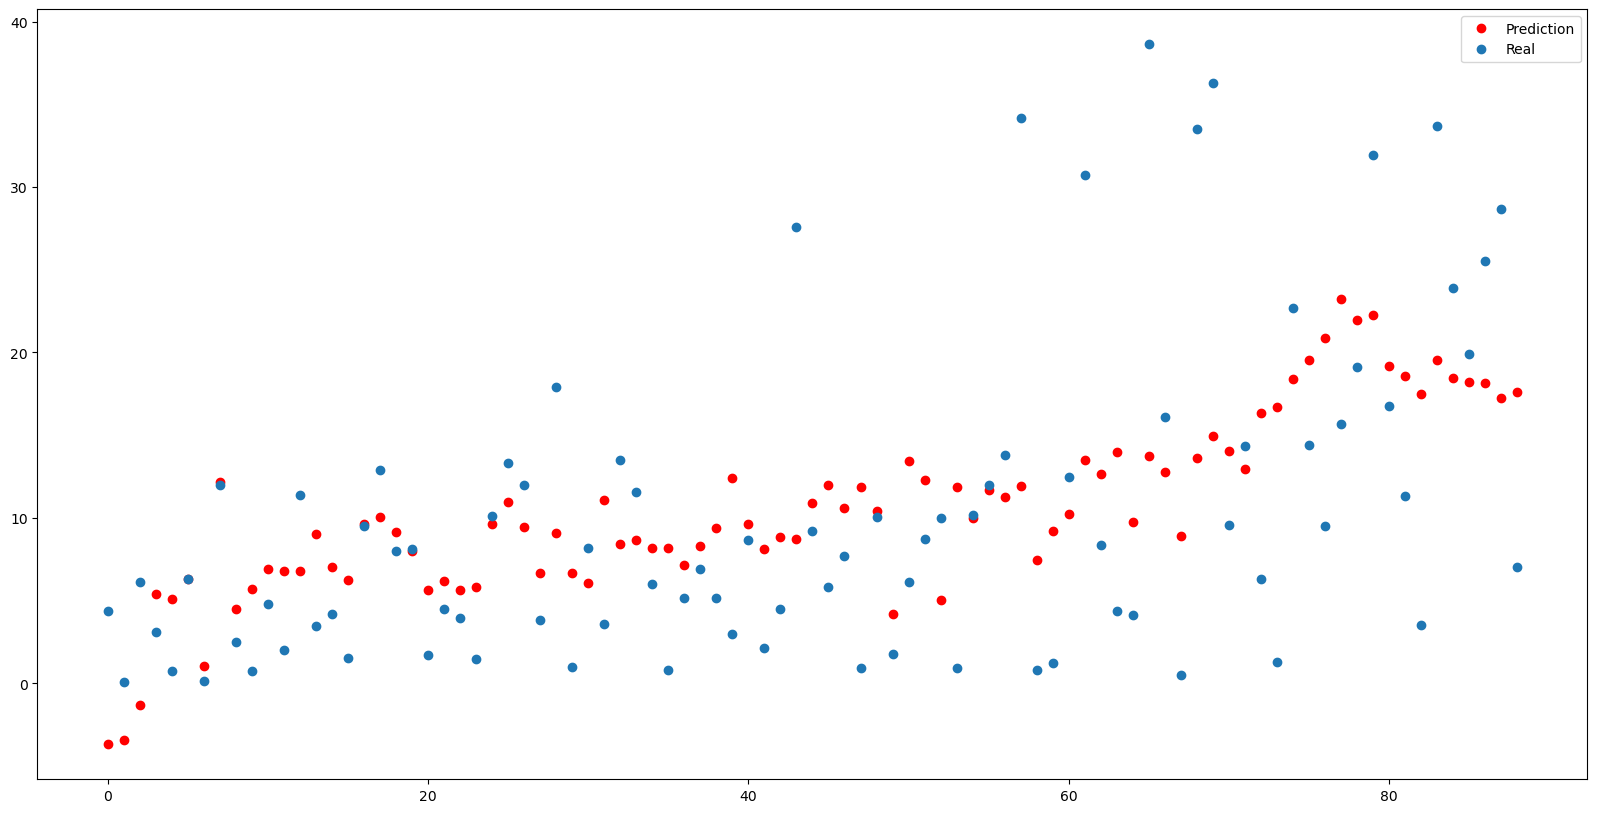

In [256]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(y_pred)), y_pred, 'ro', label = 'Prediction')
plt.plot(range(len(y)), y, 'o', label = 'Real')
plt.legend()
plt.show()

In [257]:
r2_test_dt.append(r2_score(y_test, y_pred_test))
rmse_test_dt.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
r2_dt.append(r2_score(y, y_pred))
rmse_dt.append(np.sqrt(mean_squared_error(y, y_pred)))
mae_test_dt.append(mean_absolute_error(y_test, y_pred_test))
mae_dt.append(mean_absolute_error(y, y_pred))

dt_test_scores = pd.DataFrame({'Test R^2':r2_test_dt, 'Test RMSE':rmse_test_dt, 'Test MAE':mae_test_dt})
dt_scores = pd.DataFrame({'R^2':r2_dt, 'RMSE':rmse_dt, 'MAE':mae_dt})
dt_scores

,R^2,RMSE,MAE
0,0.299257,7.946496,5.907132


In [258]:
dt_test_scores

,Test R^2,Test RMSE,Test MAE
0,0.292293,8.692288,6.100507


### Mejores Scores de R^2 de los 4 modelos para el dataset completo.

In [259]:
best_plr_score = plr_scores['R^2'].idxmax()
max_plr = plr_scores.loc[best_plr_score]
print('Regresion polinomica:\n', max_plr)

Regresion polinomica:
 degree    3.000000
R^2       0.429632
RMSE      7.169249
MAE       5.359948
Name: 1, dtype: float64


In [260]:
best_lasso_score = lasso_scores['R^2'].idxmax()
max_lasso = lasso_scores.loc[best_lasso_score]
print('Regresion Lasso:\n', max_lasso)

Regresion Lasso:
 alpha    0.001000
R^2      0.299447
RMSE     7.945415
MAE      5.907212
Name: 3, dtype: float64


In [261]:
best_ridge_score = ridge_scores['R^2'].idxmax()
max_ridge = ridge_scores.loc[best_ridge_score]
print('Regresion Ridge:\n', max_ridge)

Regresion Ridge:
 alpha    0.001000
R^2      0.299453
RMSE     7.945382
MAE      5.907408
Name: 3, dtype: float64


In [262]:
best_dt_score = dt_scores['R^2'].idxmax()
max_dt = dt_scores.loc[best_dt_score]
print('Regresion Arbol Aleatorio:\n', max_dt)

Regresion Arbol Aleatorio:
 R^2     0.299257
RMSE    7.946496
MAE     5.907132
Name: 0, dtype: float64


### Mi intención fue encontrar el mejor modelo que a partir de la distancia de separación con la planta, se pueda predecir qué  niveles de radiación se pudieran encontrar, pero notamos que nuestro mejor modeo, la regresión polinomal de 3er grado, nos muestra un score de R^2 de alrededor de .43, lo que nos dice que, aunque es el mejor modelo, la distancia entre chernobyl y los puntos de medición no es suficientemente buen predictor.